In [38]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import torch
import torch.nn as nn
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [ ]:
import pickle
import lightgbm as lgb

class RiskClassifier:
    def __init__(self):
        self.model = lgb.LGBMClassifier(random_state=42, is_unbalance=True)
        self.features = [
            'open', 'high', 'low', 'close', 'volume',
            'ema_50', 'ema_200', 'macd', 'macd_signal', 'macd_diff', 'rsi',
            'bollinger_hband', 'bollinger_lband', 'mfi',
            'return', 'bollinger_pct', 'bollinger_bw',
            'volatility_5d', 'volatility_10d',
            'volume_change', 'obv', 'volume_pct_20d', 'close_lag1', 'close_lag2',
            'close_lag3', 'return_lag1', 'return_lag2', 'return_lag3', 'rsi_lag1',
            'rsi_lag2', 'rsi_lag3', 'macd_lag1', 'macd_lag2', 'macd_lag3',
            'macd_diff_lag1', 'macd_diff_lag2', 'macd_diff_lag3',
            'bollinger_pct_lag1', 'bollinger_pct_lag2', 'bollinger_pct_lag3'
        ]

    def train(self, df_train_featured):
        df_train = df_train_featured.copy()
        
        test_size = 0.20
        all_Xtrain_dfs = []
        all_ytrain_dfs = []
        

        for ticker in df_train["ticker"].unique():
            df_ticker = df_train[df_train["ticker"] == ticker].copy()
            df_ticker.sort_values(by = "timestamp", inplace = True)
            split_index = int((len(df_ticker) * (1-test_size)))
            df_ticker_train = df_ticker[:split_index]
            all_Xtrain_dfs.append(df_ticker_train[self.features])
            all_ytrain_dfs.append(df_ticker_train["risk_label"])
        

        X_train = pd.concat(all_Xtrain_dfs)
        y_train = pd.concat(all_ytrain_dfs)
         
        self.model.fit(X_train, y_train)
        print("[Risk Model] Huấn luyện xong")

    def predict(self, df_today_featured):
        if df_today_featured.empty:
            return pd.Series(dtype=int)

        
        X_today = df_today_featured[self.features].dropna()
        if X_today.empty:
            return pd.Series(dtype=int)
            
        predictions = self.model.predict(X_today)
        return pd.Series(predictions, index=X_today.index)
    
    def load_model(self, model_path: str):
        """Load model đã được lưu bằng pickle (.pkl)."""
        with open(model_path, "rb") as f:
            self.model = pickle.load(f)
        return self.model

In [40]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_classes, num_layers=2, dropout=0.3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, num_classes)

    def forward(self, input_seq):
        device = input_seq.device
        h0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(device)
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [41]:
class SignalClassifier:
    def __init__(self, model_path, top_features, scaler_path,
                 time_steps=10, device="cpu"):
        self.model_path = model_path
        self.top_features = top_features
        self.scaler_path = scaler_path
        self.time_steps = time_steps
        self.device = device
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def load_model(self, input_size, num_classes=3, hidden_size=128):
        with open(self.scaler_path, "rb") as f:
            self.scaler = pickle.load(f)

        model = LSTMClassifier(input_size=input_size, hidden_layer_size=hidden_size, num_classes=num_classes)
        model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        self.model = model
        print(f"[Signal Model] Load weight từ {self.model_path} thành công")
        print(f"[Signal Model] Load scaler từ {self.scaler_path} thành công")

    def _create_lstm_dataset(self, X_scaled):
        if len(X_scaled) < self.time_steps:
            return np.array([])
        return X_scaled[-self.time_steps:].reshape(1, self.time_steps, X_scaled.shape[1])

    def predict(self, df_history_featured):
        if df_history_featured.empty or len(df_history_featured) < self.time_steps:
            return 1 

        X_hist = df_history_featured[self.top_features].values
        X_hist_scaled = self.scaler.transform(X_hist)

        X_lstm = self._create_lstm_dataset(X_hist_scaled)
        if X_lstm.shape[0] == 0:
            return 1 
        
        X_tensor = torch.tensor(X_lstm, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            output = self.model(X_tensor)
            pred = torch.argmax(output, dim=1).item()
        
        return pred

In [42]:
def add_features(df):
    df_copy = df.copy()

    # Features cho Risk Model
    df_copy["volatility_5d"] = df_copy.groupby("ticker")["return"].rolling(5).std().reset_index(0, drop=True)
    df_copy["volatility_10d"] = df_copy.groupby("ticker")["return"].rolling(10).std().reset_index(0, drop=True)

    df_copy["volume_change"] = df_copy.groupby("ticker")["volume"].pct_change()
    
    df_copy["obv"] = (np.sign(df_copy["return"].fillna(0)) * df_copy["volume"]).groupby(df_copy["ticker"]).cumsum()
    
    df_copy["volume_pct_20d"] = df_copy.groupby("ticker")["volume"].transform(
        lambda x: x.rolling(20).apply(lambda s: pd.Series(s).rank(pct=True).iloc[-1])
    )

    lag_cols = ["close", "return", "rsi", "macd", "macd_diff", "bollinger_pct"]
    for col in lag_cols:
        for lag in [1, 2, 3]:
            df_copy[f"{col}_lag{lag}"] = df_copy.groupby("ticker")[col].shift(lag)
    
    # Features cho Signal Model
    lags = [5, 10, 15]
    for lag in lags:
        df_copy[f'return_lag_{lag}'] = df_copy.groupby('ticker')['return'].shift(lag)

    vol_windows = [10, 20]
    for window in vol_windows:
        df_copy[f'volatility_{window}'] = df_copy.groupby('ticker')['return'].rolling(window=window).std().reset_index(0, drop=True)

    df_copy['rsi_momentum'] = df_copy.groupby('ticker')['rsi'].diff()
    df_copy['macd_diff_momentum'] = df_copy.groupby('ticker')['macd_diff'].diff()
    df_copy['price_vs_ema200'] = (df_copy['close'] / df_copy['ema_200']) - 1

    indicators_to_lag = ['rsi', 'mfi']
    for indicator in indicators_to_lag:
        for lag in [1, 3]:
            df_copy[f'{indicator}_lag_{lag}'] = df_copy.groupby('ticker')[indicator].shift(lag)

    return df_copy

def calculate_risk_label(df):
    df['min_price_in_future'] = df.groupby('ticker')['low'].shift(-10).rolling(window=10).min()

    df['future_max_drawdown'] = (df['min_price_in_future'] / df["close"]) - 1

    df.dropna(subset=['future_max_drawdown'], inplace=True)

    df['T2_drawdown'] = df.groupby('timestamp')['future_max_drawdown'].transform(lambda x: x.quantile(0.35))

    labels = [1, 0]
    conditions = [
        df['future_max_drawdown'] <= df['T2_drawdown'],
        df['future_max_drawdown'] > df['T2_drawdown']
    ]
    df['risk_label'] = np.select(conditions, labels)

    return df


In [43]:
def create_all_features(df, window_size=252):
    df_copy = df.copy()

    df_vnx = df[df["exchange"] == "HOSE"]
    df_hnx = df[df["exchange"] == "HNX"]
    df_upcom = df[df["exchange"] == "UPCOM"]

    df_vnx = calculate_risk_label(df_vnx)
    df_hnx = calculate_risk_label(df_hnx)
    df_upcom = calculate_risk_label(df_upcom)

    df_vnx = add_features(df_vnx)
    df_hnx = add_features(df_hnx)
    df_upcom = add_features(df_upcom)
    
    return df_vnx, df_hnx, df_upcom

In [44]:
def filter_ticker(vnx_finance_path, hnx_finance_path, upcom_finance_path):
    list_qualified_tickers = []
    df_vnx = pd.read_excel(vnx_finance_path)
    df_hnx = pd.read_excel(hnx_finance_path)
    df_upcom = pd.read_excel(upcom_finance_path)

    for ticker in df_hnx["ticker"].unique():
        row = df_hnx[df_hnx["ticker"] == ticker].iloc[0]  
        if (
            row["EBITMargin"] >= 0.03
            and row["ROA"] >= 0.01
            and row["ROE"] >= 0.01
            and row["ROIC"] >= 0.02
        ):
            list_qualified_tickers.append(ticker)

    
    for ticker in df_vnx["ticker"].unique():
        row = df_vnx[df_vnx["ticker"] == ticker].iloc[0]  
        if (
            row["EBITMargin"] >= 0.05
            and row["ROA"] >= df_vnx["ROA"].quantile(0.25)
            and row["ROE"] >= df_vnx["ROE"].quantile(0.25)
            and row["ROIC"] >= 0.04
        ):
            list_qualified_tickers.append(ticker)

    for ticker in df_upcom["ticker"].unique():
        row = df_upcom[df_upcom["ticker"] == ticker].iloc[0]  
        if (
            row["EBITMargin"] >= df_upcom["EBITMargin"].quantile(0.35)
            and row["ROA"] >= df_upcom["ROA"].quantile(0.25)
            and row["ROE"] >= df_upcom["ROE"].quantile(0.25)
            and row["ROIC"] >= df_upcom["ROIC"].quantile(0.35)
        ):
            list_qualified_tickers.append(ticker)

    return list_qualified_tickers

VNX_FINANCE_PATH = r"/kaggle/input/vnx-finance/VNINDEX_Finance.xlsx"
HNX_FINANCE_PATH = r"/kaggle/input/hnx-finance/HNXINDEX_Finance.xlsx"
UPCOM_FINANCE_PATH = r"/kaggle/input/upcom-finance/UPCOMINDEX_Finance.xlsx"
list_qualified_tickers = filter_ticker(VNX_FINANCE_PATH, HNX_FINANCE_PATH, UPCOM_FINANCE_PATH)
print(len(list_qualified_tickers))

561


In [45]:
def filter_ticker_by_indicators(data):
    # Ngưỡng chỉ số cho VN-Index
    vn_rsi_low, vn_rsi_high = 30, 70
    vn_macd_low, vn_macd_high = -190.806461, 191.497498
    vn_boll_low, vn_boll_high = 0.247301, 0.769456

    # Ngưỡng chỉ số cho HNX-Index 
    hnx_rsi_low, hnx_rsi_high = 25, 75
    hnx_macd_low, hnx_macd_high = -171.424148, 176.457420
    hnx_boll_low, hnx_boll_high = 0.230735, 0.735965

    # Ngưỡng chỉ số cho UPCOM 
    upcom_rsi_low, upcom_rsi_high = 20, 80
    upcom_macd_low, upcom_macd_high = -161.357600, 163.167889
    upcom_boll_low, upcom_boll_high = 0.224304, 0.733178

    # Lọc cổ phiếu cho từng sàn
    vn_filtered = data[
        (data['exchange'] == 'VN') &
        (data['rsi'] >= vn_rsi_low) & (data['rsi'] <= vn_rsi_high) &
        (data['macd_diff'] >= vn_macd_low) & (data['macd_diff'] <= vn_macd_high) &
        (data['bollinger_pct'] >= vn_boll_low) & (data['bollinger_pct'] <= vn_boll_high)
    ]

    hnx_filtered = data[
        (data['exchange'] == 'HNX') &
        (data['rsi'] >= hnx_rsi_low) & (data['rsi'] <= hnx_rsi_high) &
        (data['macd_diff'] >= hnx_macd_low) & (data['macd_diff'] <= hnx_macd_high) &
        (data['bollinger_pct'] >= hnx_boll_low) & (data['bollinger_pct'] <= hnx_boll_high)
    ]

    upcom_filtered = data[
        (data['exchange'] == 'UPCOM') &
        (data['rsi'] >= upcom_rsi_low) & (data['rsi'] <= upcom_rsi_high) &
        (data['macd_diff'] >= upcom_macd_low) & (data['macd_diff'] <= upcom_macd_high) &
        (data['bollinger_pct'] >= upcom_boll_low) & (data['bollinger_pct'] <= upcom_boll_high)
    ]


    filtered_df = pd.concat([vn_filtered, hnx_filtered, upcom_filtered], ignore_index=True)

    return filtered_df




In [ ]:
def run_backtest(all_df, RiskClassifier, SignalClassifier, vnindex_df, # << Thêm vnindex_df làm tham số
                 risk_model_params={},
                 signal_model_params={},
                 initial_balance=1_000_000_000,
                 trailing_stop_percent=0.07,
                 initial_stop_loss_percent=0.08,
                 min_hold_period=10,
                 max_hold_period=20,
                 full_take_profit_percent=0.20,
                 partial_take_profit_percent = 0.10,
                 partial_take_profit_amount = 0.5,
                 max_concurrent_positions=15,   
                ):
    # --- B0: Feature Engineering ---
    df_vnx, df_hnx, df_upcom = create_all_features(all_df)
    all_df_featured = pd.concat([df_vnx, df_hnx, df_upcom], ignore_index= True)
    all_df_featured.dropna(inplace=True)
    all_df_featured = all_df_featured.sort_values("timestamp").set_index("timestamp")

    # --- Chia train/test ---
    unique_dates = all_df_featured.index.unique().sort_values()
    split_idx = int(0.80 * len(unique_dates))
    train_cutoff = unique_dates[split_idx]
    train_df = all_df_featured.loc[all_df_featured.index <= train_cutoff]
    test_df_raw = all_df_featured.loc[all_df_featured.index > train_cutoff]

    dates_to_drop = [
        '2025-05-08', '2025-06-05', '2025-06-12', '2025-06-17',
        '2025-06-25', '2025-06-30', '2025-07-03', '2025-01-03',
        '2025-04-21', '2025-01-20', '2025-04-24', '2025-01-16'
    ]
    
   
    test_df_dates_str = pd.to_datetime(test_df_raw.index).strftime('%Y-%m-%d')
    
    test_df = test_df_raw[~np.isin(test_df_dates_str, dates_to_drop)]

    # Train Risk model 
    risk_model_vnx = RiskClassifier(**risk_model_params)
    risk_model_vnx.train(df_vnx)

    risk_model_hnx = RiskClassifier(**risk_model_params)
    risk_model_hnx.train(df_hnx)

    risk_model_upcom = RiskClassifier(**risk_model_params)
    risk_model_upcom.train(df_upcom)

    # Load Signal model ---
    signal_model = SignalClassifier(**signal_model_params)
    input_size = len(signal_model.top_features)
    signal_model.load_model(input_size=input_size)

    all_trading_days = test_df.index.unique().sort_values()    
    balance = initial_balance
    trading_days = all_trading_days[:-3] 
    final_liquidation_date = all_trading_days[-3] 
    holdings = {}
    portfolio_history = []
    trade_log = []

    mdd_snapshots = [] 
    was_in_deep_drawdown = False 

    portfolio_peak_value = initial_balance 

    
    
    print("\nBẮT ĐẦU BACKTEST")
    for date in tqdm(trading_days, desc="Backtesting"):    
        df_today_full_raw = test_df.loc[[date]] 
        df_today_full = df_today_full_raw.set_index('ticker')
        df_today_filtered_raw = df_today_full_raw.copy() 
        if list_qualified_tickers:
            df_today_filtered_raw = df_today_filtered_raw[df_today_filtered_raw["ticker"].isin(list_qualified_tickers)]
        df_today_filtered_raw = filter_ticker_by_indicators(df_today_filtered_raw)
        df_today = df_today_filtered_raw.set_index('ticker')
        
       

        is_market_bullish = True 
        if date in vnindex_df.index and not np.isnan(vnindex_df.loc[date, 'sma200']):
            is_market_bullish = vnindex_df.loc[date, 'close'] > vnindex_df.loc[date, 'sma200']

        # --- 1. Risk & Signal Classification ---
        risk_preds = []

        mask_hose = df_today["exchange"] == "HOSE"
        if mask_hose.any():
            preds_hose = risk_model_vnx.predict(df_today.loc[mask_hose])
            risk_preds.extend(list(zip(df_today.loc[mask_hose].index, preds_hose)))

        mask_hnx = df_today["exchange"] == "HNX"
        if mask_hnx.any():
            preds_hnx = risk_model_hnx.predict(df_today.loc[mask_hnx])
            risk_preds.extend(list(zip(df_today.loc[mask_hnx].index, preds_hnx)))

        mask_upcom = df_today["exchange"] == "UPCOM"
        if mask_upcom.any():
            preds_upcom = risk_model_upcom.predict(df_today.loc[mask_upcom])
            risk_preds.extend(list(zip(df_today.loc[mask_upcom].index, preds_upcom)))

        risk_preds_series = pd.Series(dict(risk_preds))

        eligible_tickers = risk_preds_series[risk_preds_series == 0].index.tolist()
        if eligible_tickers:
            print(f"\n[{date}] Các mã đủ điều kiện: {len(eligible_tickers)} - {eligible_tickers}")
        
        signals = {}
        if eligible_tickers:
            for ticker in eligible_tickers:
                hist_data = all_df_featured[all_df_featured["ticker"] == ticker].loc[:date].copy()
                if not hist_data.empty:
                    signal = signal_model.predict(hist_data)
                    signals[ticker] = signal
        
        buy_signals = {t: s for t, s in signals.items() if s == 2}
        sell_signals = {t: s for t, s in signals.items() if s == 0}
        
        if eligible_tickers:
             print(f"\n[{date}] Mã đủ điều kiện rủi ro: {len(eligible_tickers)}")
        if signals:
            print(f"  -> Tín hiệu: Mua: {len(buy_signals)}, Bán: {len(sell_signals)}, Giữ: {len(signals) - len(buy_signals) - len(sell_signals)}")

        # --- 2. Quản lý Holdings ---
        current_holdings = list(holdings.keys())
        for ticker in current_holdings:
            if ticker in df_today_full.index:
                current_price = df_today_full.loc[ticker, "close"]
                entry_price = holdings[ticker]['entry_price']
                
                holdings[ticker]['high_since_entry'] = max(holdings[ticker]['high_since_entry'], current_price)
                holdings[ticker]['trailing_stop'] = holdings[ticker]['high_since_entry'] * (1 - trailing_stop_percent)
                holdings[ticker]['days_held'] += 1

                should_sell = False
                reason_to_sell = ""

                current_profit_percent = (current_price / entry_price) - 1
                if not holdings[ticker]['partial_profit_taken']:
                    if current_profit_percent >= partial_take_profit_percent:
                        shares_to_sell = int(holdings[ticker]['shares'] * partial_take_profit_amount) 
                        if shares_to_sell > 0:
                            balance += shares_to_sell * current_price
                            holdings[ticker]['shares'] -= shares_to_sell 
                            holdings[ticker]['partial_profit_taken'] = True
                            
                            trade_log.append({
                                'ticker': ticker, 'entry_date': holdings[ticker]['entry_date'], 'exit_date': date,
                                'entry_price': entry_price, 'exit_price': current_price, 'shares': shares_to_sell,
                                'trade_type': 'Partial Take Profit (Profit Target)'
                            })
                            print(f"  -> CHỐT LỜI 1/2: {shares_to_sell} {ticker} tại giá {current_price:,.0f} (Lãi {current_profit_percent:.2%})")
                
                if current_profit_percent >= full_take_profit_percent:
                    should_sell = True
                    reason_to_sell = f"Take Profit ({full_take_profit_percent:.0%})"
                

                elif current_price <= holdings[ticker].get('initial_stop_price', 0):
                    should_sell = True
                    reason_to_sell = "Initial Stop-loss"
                    
                elif current_price <= holdings[ticker]['trailing_stop']:
                    should_sell = True
                    reason_to_sell = "Trailing Stop"
                    
                elif holdings[ticker]['days_held'] >= min_hold_period:
                    if signals.get(ticker, 1) == 0:
                        should_sell = True
                        reason_to_sell = "SignalClassifier BÁN"
                    elif holdings[ticker]['days_held'] >= max_hold_period:
                        should_sell = True
                        reason_to_sell = f"Max Hold Period ({max_hold_period} days)"
                        
                if should_sell and holdings[ticker]['shares'] > 0:
                    balance += holdings[ticker]['shares'] * current_price
                    trade_log.append({
                        'ticker': ticker, 'entry_date': holdings[ticker]['entry_date'], 'exit_date': date,
                        'entry_price': entry_price, 'exit_price': current_price, 'shares': holdings[ticker]['shares'],
                        'trade_type': reason_to_sell
                    })
                    print(f"  -> BÁN TOÀN BỘ: {holdings[ticker]['shares']} {ticker} tại giá {current_price:,.0f} ({reason_to_sell})")
                    del holdings[ticker]

        # Các bước mua

        buy_tickers_today = [t for t, s in buy_signals.items() if t not in holdings]

        if buy_tickers_today and is_market_bullish:
            slots_available = max_concurrent_positions - len(holdings)
            
            if slots_available <= 0:
                print("  -> Đã đạt giới hạn số lượng vị thế. Không mua mới.")
            else:
                buy_tickers_to_consider = buy_tickers_today[:slots_available]
                
                risk_per_trade_percent = 0.01 
                initial_stop_loss_percent = 0.08
                max_capital_deployment_per_day = 0.40
                
                # Tính tổng giá trị tài sản hiện tại (tiền mặt + giá trị cổ phiếu)
                holdings_value = 0
                for ticker_held, info_held in holdings.items():
                    if ticker_held in df_today_full.index:
                        holdings_value += info_held['shares'] * df_today_full.loc[ticker_held, "close"]
                total_portfolio_value = balance + holdings_value
                
                # Tính toán tổng vốn có thể triển khai trong ngày hôm nay
                capital_to_deploy_today = total_portfolio_value * max_capital_deployment_per_day
                
                print(f"  -> Ngân sách triển khai vốn ngày hôm nay: {capital_to_deploy_today:,.0f} VNĐ")
                
                for ticker in buy_tickers_to_consider: 
                    if capital_to_deploy_today <= 0:
                        print("  -> Đã hết ngân sách triển khai vốn cho ngày hôm nay.")
                        break 
        
                    if ticker in df_today_full.index:
                        price = df_today_full.loc[ticker, "close"]
                        
                        stop_loss_price = price * (1 - initial_stop_loss_percent)
                        
                        risk_per_share = price - stop_loss_price
        
                        if price > 0 and risk_per_share > 0:
                            capital_at_risk = total_portfolio_value * risk_per_trade_percent
                            
                            shares = int(capital_at_risk // risk_per_share)
                            
                            position_value = shares * price
                            
                            if shares > 0 and position_value <= balance and position_value <= capital_to_deploy_today:
                                balance -= position_value
                                capital_to_deploy_today -= position_value # Trừ vào ngân sách ngày
                                
                                holdings[ticker] = {
                                    'shares': shares, 
                                    'entry_price': price, 
                                    'entry_date': date, 
                                    'high_since_entry': price,
                                    'trailing_stop': price * (1 - trailing_stop_percent),
                                    'initial_stop_price': stop_loss_price,
                                    'days_held': 0, 
                                    'partial_profit_taken': False, 
                                    'status': 'initial'
                                }
                                print(f"  -> MUA: {shares} {ticker} tại giá {price:,.0f} (Vốn: {position_value:,.0f} VNĐ, Rủi ro: {capital_at_risk:,.0f} VNĐ)")
                            
                            elif position_value > balance:
                                print(f"  [CẢNH BÁO] Không đủ tiền mặt để mua {ticker}. Cần {position_value:,.0f}, còn {balance:,.0f}")
                            elif position_value > capital_to_deploy_today:
                                print(f"  [THÔNG TIN] Bỏ qua mua {ticker} vì vượt quá ngân sách triển khai vốn còn lại trong ngày.")
        

        elif not is_market_bullish:
            print(f"  -> [{date.date()}] Bỏ qua tín hiệu mua do thị trường chung xấu.")


        holdings_value = 0
        for ticker, info in holdings.items():
            if ticker in df_today_full.index:
                holdings_value += info['shares'] * df_today_full.loc[ticker, "close"]
        total_value = balance + holdings_value
        portfolio_history.append({'date': date, 'value': total_value})
        
        portfolio_peak_value = max(portfolio_peak_value, total_value)
        
        # Tính toán mức sụt giảm hiện tại từ đỉnh
        current_drawdown = (total_value - portfolio_peak_value) / portfolio_peak_value

       
        mdd_threshold = -0.50 # Ngưỡng 50%

        # Điều kiện: Vừa mới sụt giảm xuống dưới ngưỡng
        if current_drawdown <= mdd_threshold and not was_in_deep_drawdown:
            print(f"\n{'#'*10} CẢNH BÁO: DANH MỤC VỪA SỤT GIẢM VƯỢT {mdd_threshold:.0%} {'#'*10}")
            
            # Tạo một "ảnh chụp" mới
            current_snapshot = {
                'date': date,
                'drawdown': current_drawdown,
                'holdings_at_mdd': []
            }
            
            # Lặp qua các cổ phiếu đang nắm giữ tại thời điểm đó
            for ticker_held, info_held in holdings.items():
                current_price_at_mdd = df_today_full.loc[ticker_held, "close"] if ticker_held in df_today_full.index else np.nan
                current_snapshot['holdings_at_mdd'].append({
                    'ticker': ticker_held,
                    'entry_price': info_held['entry_price'],
                    'current_price': current_price_at_mdd
                })

            # Thêm ảnh chụp vào danh sách và cập nhật trạng thái
            mdd_snapshots.append(current_snapshot)
            was_in_deep_drawdown = True
        
        # Điều kiện: Vừa mới phục hồi lên trên ngưỡng
        elif current_drawdown > mdd_threshold and was_in_deep_drawdown:
            # Reset trạng thái để sẵn sàng ghi nhận cho lần sụt giảm tiếp theo
            was_in_deep_drawdown = False

    df_final_day_raw = test_df.loc[final_liquidation_date]

    if isinstance(df_final_day_raw, pd.Series):
        df_final_day = df_final_day_raw.to_frame().T
    else:
        df_final_day = df_final_day_raw.copy()
    df_final_day = df_final_day.set_index('ticker')

    for ticker, info in list(holdings.items()):
        if ticker in df_final_day.index and not np.isnan(df_final_day.loc[ticker, "close"]):
            final_price = df_final_day.loc[ticker, "close"]
            balance += info['shares'] * final_price
            trade_log.append({
                'ticker': ticker, 'entry_date': info['entry_date'], 'exit_date': final_liquidation_date,
                'entry_price': info['entry_price'], 'exit_price': final_price, 'shares': info['shares'],
                'trade_type': 'Final Liquidation'
            })
        else:
            print(f"[CẢNH BÁO] Mã {ticker} không có dữ liệu vào ngày thanh lý {final_liquidation_date}. Ghi nhận lỗ.")
            trade_log.append({
                'ticker': ticker, 'entry_date': info['entry_date'], 'exit_date': final_liquidation_date,
                'entry_price': info['entry_price'], 'exit_price': 0, 'shares': info['shares'],
                'trade_type': 'Liquidation Failed (Assumed 0)'
            })

    final_total_value = balance

    # Tạo một dòng cuối cùng trong lịch sử danh mục cho ngày thanh lý
    if portfolio_history:
    # Lấy ngày giao dịch cuối cùng (ngày áp chót)
        last_trading_day_entry = portfolio_history[-1]
        # Cập nhật giá trị của ngày đó bằng giá trị sau khi đã thanh lý
        last_trading_day_entry['value'] = final_total_value
        # Ghi đè lại vào danh sách
        portfolio_history[-1] = last_trading_day_entry

    if mdd_snapshots:
        print("\n" + "="*80)
        print("--- PHÂN TÍCH CÁC THỜI ĐIỂM DANH MỤC SỤT GIẢM > 50% ---")
        print("="*80)
        
        # Lặp qua từng lần sụt giảm đã ghi nhận
        for i, snapshot in enumerate(mdd_snapshots, 1):
            mdd_date = snapshot['date']
            mdd_percent = snapshot['drawdown']
            
            print(f"\nLẦN SỤT GIẢM THỨ {i}:")
            print(f"Ngày ghi nhận: {mdd_date} (Mức sụt giảm lúc đó: {mdd_percent:.2%})")
            print("-" * 70)
            print(f"{'Cổ phiếu':<10} {'Giá vào lệnh':>15} {'Giá tại thời điểm sụt giảm':>30} {'Lãi/Lỗ':>12}")
            print(f"{'-'*10} {'-'*15} {'-'*30} {'-'*12}")
            
            for stock_info in snapshot['holdings_at_mdd']:
                ticker = stock_info['ticker']
                entry_price = stock_info['entry_price']
                current_price = stock_info['current_price']
                pnl_percent = (current_price / entry_price - 1) * 100 if entry_price > 0 and not np.isnan(current_price) else 0
                
                print(f"{ticker:<10} {entry_price:,.0f}{' VND':>10} {current_price:,.0f}{' VND':>20} {pnl_percent:>10.2f}%")
            print("-" * 70)
    else:
        print("\n[THÔNG TIN] Mức sụt giảm tối đa của chiến lược không vượt quá 50%.")


    portfolio_history_df = pd.DataFrame(portfolio_history).set_index('date')

    return portfolio_history_df, pd.DataFrame(trade_log)

In [ ]:
import yfinance as yf
import numpy as np 

def analyze_performance(portfolio_df, trade_log_df, initial_balance):
    portfolio_df = portfolio_df.copy()
    trade_log_df = trade_log_df.copy() if not trade_log_df.empty else trade_log_df

    if portfolio_df.empty:
        print("Không có dữ liệu hiệu suất để phân tích.")
        return

    print("\n--- PHÂN TÍCH HIỆU SUẤT CHIẾN LƯỢC ---")
    
    # 1. Các chỉ số cơ bản
    final_value = portfolio_df['value'].iloc[-1]
    total_return_pct = (final_value / initial_balance - 1) * 100
    
    print(f"Vốn ban đầu:              {initial_balance:,.0f} VND")
    print(f"Giá trị cuối cùng:           {final_value:,.0f} VND")
    print(f"Tổng lợi nhuận:            {total_return_pct:.2f}%")

    # 2. Phân tích giao dịch
    if not trade_log_df.empty:
        total_trades = len(trade_log_df)
        trade_log_df['pnl'] = (trade_log_df['exit_price'] - trade_log_df['entry_price']) * trade_log_df['shares']
        winning_trades = trade_log_df[trade_log_df['pnl'] > 0]
        win_rate = (len(winning_trades) / total_trades) * 100 if total_trades > 0 else 0.0
        
        print(f"Tổng số giao dịch:        {total_trades}")
        print(f"Tỷ lệ chiến thắng (Win Rate): {win_rate:.2f}%")
    else:
        print("Tổng số giao dịch:        0")
        print("Tỷ lệ chiến thắng (Win Rate): N/A")

    # 3. Mức sụt giảm tối đa (Maximum Drawdown)
    portfolio_df['peak'] = portfolio_df['value'].cummax()
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    max_drawdown = portfolio_df['drawdown'].min() * 100
    
    print(f"Mức sụt giảm tối đa (Max DD): {max_drawdown:.2f}%")

    

[LightGBM] [Info] Number of positive: 59770, number of negative: 111494
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9985
[LightGBM] [Info] Number of data points in the train set: 171264, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348993 -> initscore=-0.623467
[LightGBM] [Info] Start training from score -0.623467
[Risk Model] Huấn luyện xong
[LightGBM] [Info] Number of positive: 17717, number of negative: 32032
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9986
[LightGBM] [Info] Number of data points in the train set: 49749, number of used 

Backtesting:   0%|          | 0/151 [00:00<?, ?it/s]


[2024-12-25 00:00] Các mã đủ điều kiện: 21 - ['VCS', 'NAG', 'L18', 'TIG', 'L14', 'IDV', 'VC2', 'IDC', 'VC3', 'SCG', 'DXP', 'PBC', 'QNS', 'HD6', 'HND', 'FOX', 'DVN', 'AMS', 'SCL', 'GHC', 'NED']


Backtesting:   1%|          | 1/151 [00:00<01:43,  1.45it/s]


[2024-12-25 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 17
  -> Ngân sách triển khai vốn ngày hôm nay: 400,000,000 VNĐ
  -> MUA: 9124 TIG tại giá 13,700 (Vốn: 124,998,800 VNĐ, Rủi ro: 10,000,000 VNĐ)

[2024-12-26 00:00] Các mã đủ điều kiện: 19 - ['IDC', 'VHE', 'DXP', 'IDV', 'SD9', 'NAG', 'SCG', 'TNG', 'DTD', 'SSH', 'ACV', 'SCL', 'FOX', 'GHC', 'DVN', 'HND', 'NED', 'HD6', 'PBC']


Backtesting:   1%|▏         | 2/151 [00:01<01:35,  1.57it/s]


[2024-12-26 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 0, Bán: 0, Giữ: 19

[2024-12-27 00:00] Các mã đủ điều kiện: 24 - ['SCG', 'DHT', 'IDC', 'VHE', 'VC2', 'DXP', 'HBS', 'DTD', 'C69', 'BVS', 'LAS', 'NAG', 'TNG', 'VCS', 'GHC', 'CLX', 'ACV', 'HND', 'PBC', 'SCL', 'VLB', 'AFX', 'DVN', 'FOX']


Backtesting:   2%|▏         | 3/151 [00:02<01:42,  1.45it/s]


[2024-12-27 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 6, Bán: 4, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 398,905,120 VNĐ
  -> MUA: 18887 HBS tại giá 6,600 (Vốn: 124,654,200 VNĐ, Rủi ro: 9,972,628 VNĐ)
  -> MUA: 5375 DTD tại giá 23,190 (Vốn: 124,648,884 VNĐ, Rủi ro: 9,972,628 VNĐ)
  -> MUA: 7767 CLX tại giá 16,048 (Vốn: 124,647,879 VNĐ, Rủi ro: 9,972,628 VNĐ)
  [THÔNG TIN] Bỏ qua mua VLB vì vượt quá ngân sách triển khai vốn còn lại trong ngày.
  [THÔNG TIN] Bỏ qua mua AFX vì vượt quá ngân sách triển khai vốn còn lại trong ngày.
  [THÔNG TIN] Bỏ qua mua DVN vì vượt quá ngân sách triển khai vốn còn lại trong ngày.

[2024-12-30 00:00] Các mã đủ điều kiện: 23 - ['VC2', 'IDC', 'NTP', 'DTD', 'BVS', 'TNG', 'VHE', 'SCG', 'DXP', 'LAS', 'VCS', 'L18', 'SD9', 'VLB', 'SSH', 'C4G', 'DVN', 'HND', 'AFX', 'GHC', 'HD6', 'PBC', 'CLX']


Backtesting:   3%|▎         | 4/151 [00:02<01:43,  1.43it/s]


[2024-12-30 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 395,792,955 VNĐ
  -> MUA: 2410 NTP tại giá 51,321 (Vốn: 123,683,140 VNĐ, Rủi ro: 9,894,824 VNĐ)
  -> MUA: 3119 VLB tại giá 39,652 (Vốn: 123,674,326 VNĐ, Rủi ro: 9,894,824 VNĐ)
  -> MUA: 16104 AFX tại giá 7,680 (Vốn: 123,678,720 VNĐ, Rủi ro: 9,894,824 VNĐ)

[2024-12-31 00:00] Các mã đủ điều kiện: 28 - ['SD9', 'LAS', 'DTD', 'L18', 'IDC', 'TNG', 'VC2', 'VCS', 'DXP', 'VHE', 'SCG', 'L14', 'IDV', 'CLX', 'AFX', 'FOX', 'BMS', 'G36', 'QNS', 'VGT', 'HD6', 'HND', 'PBC', 'NED', 'PPH', 'VLB', 'GHC', 'SSH']


Backtesting:   3%|▎         | 5/151 [00:03<01:51,  1.31it/s]


[2024-12-31 00:00] Mã đủ điều kiện rủi ro: 28
  -> Tín hiệu: Mua: 4, Bán: 5, Giữ: 19
  -> Ngân sách triển khai vốn ngày hôm nay: 395,059,188 VNĐ
  -> MUA: 12499 BMS tại giá 9,877 (Vốn: 123,447,207 VNĐ, Rủi ro: 9,876,480 VNĐ)

[2025-01-02 00:00] Các mã đủ điều kiện: 29 - ['VCS', 'SD9', 'SCG', 'DTD', 'DXP', 'TNG', 'IDV', 'IDJ', 'LAS', 'VC3', 'IDC', 'C69', 'VC2', 'L18', 'AFX', 'ABI', 'HND', 'PBC', 'CLX', 'FOX', 'NED', 'G36', 'DVN', 'SSH', 'VGT', 'VLB', 'DRI', 'QNS', 'C4G']


Backtesting:   4%|▍         | 6/151 [00:04<01:59,  1.22it/s]


[2025-01-02 00:00] Mã đủ điều kiện rủi ro: 29
  -> Tín hiệu: Mua: 3, Bán: 5, Giữ: 21

[2025-01-06 00:00] Các mã đủ điều kiện: 22 - ['SCG', 'SD9', 'C69', 'TIG', 'PVI', 'TDT', 'CAP', 'VC3', 'PPH', 'ACV', 'CLX', 'FOX', 'AMS', 'DVN', 'ABI', 'SSH', 'G36', 'NED', 'QTP', 'C4G', 'VLB', 'AFX']


Backtesting:   5%|▍         | 7/151 [00:05<01:52,  1.28it/s]


[2025-01-06 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 4, Bán: 2, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 386,867,474 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua PVI. Cần 120,863,300, còn 6,566,843

[2025-01-07 00:00] Các mã đủ điều kiện: 16 - ['SD9', 'VC3', 'TDT', 'C69', 'CAP', 'CLX', 'PPH', 'SCL', 'G36', 'C4G', 'QTP', 'ABI', 'ACV', 'NED', 'QNS', 'SSH']


Backtesting:   5%|▌         | 8/151 [00:05<01:39,  1.44it/s]


[2025-01-07 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 0, Bán: 0, Giữ: 16

[2025-01-08 00:00] Các mã đủ điều kiện: 17 - ['L18', 'SCG', 'SD9', 'IDV', 'C69', 'NAG', 'CAP', 'TDT', 'DXP', 'VC3', 'NED', 'ABI', 'QTP', 'SSH', 'ACV', 'SCL', 'PPH']


Backtesting:   6%|▌         | 9/151 [00:06<01:31,  1.54it/s]


[2025-01-08 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 0, Bán: 0, Giữ: 17

[2025-01-09 00:00] Các mã đủ điều kiện: 19 - ['C69', 'L18', 'TDT', 'VC3', 'NAG', 'DXP', 'SD9', 'SCG', 'CAP', 'SCL', 'SSH', 'C4G', 'QTP', 'NED', 'PPH', 'FOX', 'HND', 'ACV', 'ABI']


Backtesting:   7%|▋         | 10/151 [00:06<01:29,  1.58it/s]


[2025-01-09 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 0, Bán: 0, Giữ: 19

[2025-01-10 00:00] Các mã đủ điều kiện: 16 - ['SCG', 'NAG', 'TDT', 'SD9', 'CAP', 'IVS', 'VC3', 'GHC', 'QNS', 'SSH', 'FOX', 'ABI', 'QTP', 'SCL', 'CLX', 'C4G']


Backtesting:   7%|▋         | 11/151 [00:07<01:23,  1.68it/s]


[2025-01-10 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 13
  -> BÁN TOÀN BỘ: 9124 TIG tại giá 12,700 (Trailing Stop)
  -> BÁN TOÀN BỘ: 18887 HBS tại giá 6,000 (Initial Stop-loss)
  -> BÁN TOÀN BỘ: 5375 DTD tại giá 20,863 (Initial Stop-loss)
  -> BÁN TOÀN BỘ: 2410 NTP tại giá 47,602 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 375,476,010 VNĐ
  -> MUA: 2997 CAP tại giá 39,140 (Vốn: 117,304,078 VNĐ, Rủi ro: 9,386,900 VNĐ)
  -> MUA: 11559 IVS tại giá 10,151 (Vốn: 117,335,871 VNĐ, Rủi ro: 9,386,900 VNĐ)

[2025-01-13 00:00] Các mã đủ điều kiện: 15 - ['SCG', 'IVS', 'CAP', 'SD9', 'NAG', 'TDT', 'VHE', 'SSH', 'PPH', 'FOX', 'ABI', 'GHC', 'QNS', 'QTP', 'C4G']


Backtesting:   8%|▊         | 12/151 [00:07<01:17,  1.78it/s]


[2025-01-13 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 13

[2025-01-14 00:00] Các mã đủ điều kiện: 15 - ['VHE', 'NAG', 'TDT', 'IVS', 'CAP', 'SD9', 'ABI', 'SSH', 'CLX', 'C4G', 'GHC', 'G36', 'QTP', 'QNS', 'PPH']


Backtesting:   9%|▊         | 13/151 [00:08<01:13,  1.87it/s]


[2025-01-14 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 12
  -> BÁN TOÀN BỘ: 7767 CLX tại giá 15,656 (SignalClassifier BÁN)
  -> BÁN TOÀN BỘ: 16104 AFX tại giá 7,117 (Trailing Stop)

[2025-01-15 00:00] Các mã đủ điều kiện: 14 - ['VC2', 'VC3', 'SD9', 'CAP', 'IVS', 'TDT', 'HND', 'CLX', 'GHC', 'ABI', 'QTP', 'VLB', 'QNS', 'SCL']


Backtesting:   9%|▉         | 14/151 [00:08<01:09,  1.96it/s]


[2025-01-15 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 10
  -> BÁN TOÀN BỘ: 3119 VLB tại giá 39,622 (SignalClassifier BÁN)

[2025-01-17 00:00] Các mã đủ điều kiện: 23 - ['DXP', 'C69', 'L18', 'SCG', 'VC3', 'NAG', 'TNG', 'IVS', 'IDV', 'IDC', 'SD9', 'TDT', 'BVS', 'CLX', 'DVN', 'PBC', 'GHC', 'NED', 'VGT', 'SCL', 'DRI', 'VLB', 'AFX']


Backtesting:  10%|▉         | 15/151 [00:09<01:18,  1.74it/s]


[2025-01-17 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 3, Bán: 6, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 380,184,965 VNĐ
  -> MUA: 3712 L18 tại giá 31,999 (Vốn: 118,779,249 VNĐ, Rủi ro: 9,504,624 VNĐ)
  -> MUA: 16055 AFX tại giá 7,400 (Vốn: 118,807,000 VNĐ, Rủi ro: 9,504,624 VNĐ)

[2025-01-21 00:00] Các mã đủ điều kiện: 16 - ['VCS', 'DXP', 'SD9', 'TDT', 'IDJ', 'IDC', 'IVS', 'G36', 'QNS', 'HND', 'AFX', 'QTP', 'SCL', 'PBC', 'DVN', 'ACV']


Backtesting:  11%|█         | 16/151 [00:10<01:14,  1.80it/s]


[2025-01-21 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 13

[2025-01-22 00:00] Các mã đủ điều kiện: 17 - ['IVS', 'IDC', 'VC3', 'SCG', 'TDT', 'SD9', 'DXP', 'HND', 'DVN', 'QNS', 'G36', 'VLB', 'QTP', 'VGT', 'NED', 'PBC', 'AFX']


Backtesting:  11%|█▏        | 17/151 [00:10<01:13,  1.82it/s]


[2025-01-22 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 14

[2025-01-23 00:00] Các mã đủ điều kiện: 19 - ['NTP', 'VCS', 'IVS', 'LAS', 'TIG', 'IDC', 'DXP', 'SCG', 'HND', 'VLB', 'QTP', 'C4G', 'QNS', 'PBC', 'VGT', 'G36', 'ACV', 'AFX', 'AMS']


Backtesting:  12%|█▏        | 18/151 [00:11<01:15,  1.77it/s]


[2025-01-23 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 2, Bán: 6, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 376,116,174 VNĐ
  -> MUA: 14925 C4G tại giá 7,875 (Vốn: 117,534,375 VNĐ, Rủi ro: 9,402,904 VNĐ)

[2025-01-24 00:00] Các mã đủ điều kiện: 20 - ['DXP', 'SCG', 'LAS', 'VCS', 'IDC', 'CAP', 'NTP', 'BVS', 'AFX', 'CLX', 'HND', 'DRI', 'AMS', 'ACV', 'VLB', 'VGT', 'C4G', 'QNS', 'G36', 'PBC']


Backtesting:  13%|█▎        | 19/151 [00:11<01:17,  1.71it/s]


[2025-01-24 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 1, Bán: 7, Giữ: 12

[2025-02-03 00:00] Các mã đủ điều kiện: 24 - ['TNG', 'NAG', 'BVS', 'VC2', 'VC3', 'CAP', 'NTP', 'LAS', 'IDC', 'VCS', 'L18', 'TIG', 'DXP', 'CLX', 'PBC', 'ACV', 'C4G', 'NTC', 'VGT', 'DRI', 'AFX', 'QNS', 'PPH', 'VLB']


Backtesting:  13%|█▎        | 20/151 [00:12<01:23,  1.57it/s]


[2025-02-03 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 1, Bán: 10, Giữ: 13

[2025-02-04 00:00] Các mã đủ điều kiện: 20 - ['CAP', 'TDT', 'BVS', 'IDC', 'VC2', 'NAG', 'VC3', 'DXP', 'TNG', 'VCS', 'TIG', 'VGT', 'QNS', 'AFX', 'VLB', 'QTP', 'VGI', 'AMS', 'PPH', 'ACV']


Backtesting:  14%|█▍        | 21/151 [00:13<01:22,  1.58it/s]


[2025-02-04 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 2, Bán: 7, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 389,487,069 VNĐ
  -> MUA: 11842 NAG tại giá 10,277 (Vốn: 121,706,037 VNĐ, Rủi ro: 9,737,177 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua VGI. Cần 121,667,141, còn 110,949,040

[2025-02-05 00:00] Các mã đủ điều kiện: 20 - ['TDT', 'CAP', 'VCS', 'IDJ', 'HBS', 'IDC', 'VC2', 'TNG', 'TIG', 'ACV', 'VGT', 'PPH', 'DVN', 'G36', 'QNS', 'AFX', 'QTP', 'VGI', 'AMS', 'HND']


Backtesting:  15%|█▍        | 22/151 [00:13<01:21,  1.58it/s]


[2025-02-05 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 2, Bán: 7, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 390,382,405 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 121,994,400, còn 110,949,040
  [CẢNH BÁO] Không đủ tiền mặt để mua VGI. Cần 121,954,898, còn 110,949,040

[2025-02-06 00:00] Các mã đủ điều kiện: 18 - ['VC2', 'VC3', 'IDC', 'IDJ', 'TDT', 'TIG', 'C69', 'LAS', 'VCS', 'TNG', 'DHT', 'QTP', 'AMS', 'DVN', 'HND', 'AAS', 'VGT', 'AFX']


Backtesting:  15%|█▌        | 23/151 [00:14<01:19,  1.62it/s]


[2025-02-06 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 1, Bán: 7, Giữ: 10
  -> Ngân sách triển khai vốn ngày hôm nay: 391,277,949 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua AAS. Cần 122,270,325, còn 110,949,040

[2025-02-07 00:00] Các mã đủ điều kiện: 18 - ['IDV', 'LAS', 'DHT', 'VC3', 'TNG', 'TIG', 'TDT', 'NAG', 'VCS', 'IDJ', 'IDC', 'HBS', 'AMS', 'VEF', 'ACV', 'QTP', 'HND', 'VGT']


Backtesting:  16%|█▌        | 24/151 [00:15<01:17,  1.64it/s]


[2025-02-07 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 2, Bán: 6, Giữ: 10
  -> Ngân sách triển khai vốn ngày hôm nay: 394,228,724 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 123,192,900, còn 110,949,040

[2025-02-10 00:00] Các mã đủ điều kiện: 16 - ['TIG', 'VC3', 'IDJ', 'TDT', 'LAS', 'DHT', 'NAG', 'IVS', 'NTP', 'ACV', 'HND', 'G36', 'VGT', 'QNS', 'VGI', 'AMS']


Backtesting:  17%|█▋        | 25/151 [00:15<01:13,  1.72it/s]


[2025-02-10 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 2, Bán: 7, Giữ: 7
  -> BÁN TOÀN BỘ: 12499 BMS tại giá 10,534 (Max Hold Period (20 days))

[2025-02-11 00:00] Các mã đủ điều kiện: 13 - ['VC3', 'NTP', 'DXP', 'DHT', 'TDT', 'LAS', 'NED', 'QNS', 'MCH', 'AMS', 'PPH', 'HND', 'SSH']


Backtesting:  17%|█▋        | 26/151 [00:15<01:06,  1.88it/s]


[2025-02-11 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 9
  -> CHỐT LỜI 1/2: 7462 C4G tại giá 8,768 (Lãi 11.34%)

[2025-02-12 00:00] Các mã đủ điều kiện: 16 - ['NAG', 'TIG', 'LAS', 'L14', 'L18', 'DXP', 'DHT', 'NTP', 'SCG', 'TDT', 'SSH', 'MCH', 'AMS', 'QTP', 'NED', 'PPH']


Backtesting:  18%|█▊        | 27/151 [00:16<01:04,  1.91it/s]


[2025-02-12 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 7, Giữ: 8
  -> BÁN TOÀN BỘ: 3712 L18 tại giá 32,082 (SignalClassifier BÁN)

[2025-02-13 00:00] Các mã đủ điều kiện: 15 - ['SCG', 'PVI', 'L18', 'NAG', 'TDT', 'IDJ', 'BVS', 'NTP', 'IDV', 'DXP', 'IDC', 'DHT', 'PPH', 'MCH', 'VGT']


Backtesting:  19%|█▊        | 28/151 [00:16<01:02,  1.96it/s]


[2025-02-13 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 2, Bán: 4, Giữ: 9
  -> Ngân sách triển khai vốn ngày hôm nay: 395,989,737 VNĐ
  -> MUA: 1874 PVI tại giá 66,000 (Vốn: 123,684,000 VNĐ, Rủi ro: 9,899,743 VNĐ)

[2025-02-14 00:00] Các mã đủ điều kiện: 12 - ['IDV', 'SCG', 'PVI', 'DHT', 'DXP', 'IDC', 'TDT', 'IDJ', 'NAG', 'TNG', 'AMS', 'HND']


Backtesting:  19%|█▉        | 29/151 [00:17<00:57,  2.12it/s]


[2025-02-14 00:00] Mã đủ điều kiện rủi ro: 12
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 10

[2025-02-17 00:00] Các mã đủ điều kiện: 14 - ['DXP', 'TNG', 'C69', 'TDT', 'L18', 'NAG', 'SCG', 'IDC', 'DHT', 'IDV', 'VC2', 'IDJ', 'AMS', 'VEF']


Backtesting:  20%|█▉        | 30/151 [00:17<00:56,  2.16it/s]


[2025-02-17 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 12
  -> CHỐT LỜI 1/2: 5779 IVS tại giá 11,246 (Lãi 10.78%)

[2025-02-18 00:00] Các mã đủ điều kiện: 15 - ['IDC', 'TDT', 'IDV', 'VC2', 'TNG', 'L14', 'DHT', 'L18', 'NAG', 'QNS', 'NTC', 'NED', 'VGT', 'SSH', 'AMS']


Backtesting:  21%|██        | 31/151 [00:18<00:55,  2.14it/s]


[2025-02-18 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 2, Bán: 3, Giữ: 10
  -> BÁN TOÀN BỘ: 2997 CAP tại giá 41,738 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 5780 IVS tại giá 11,047 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 398,918,387 VNĐ
  -> MUA: 4183 L14 tại giá 29,800 (Vốn: 124,653,400 VNĐ, Rủi ro: 9,972,960 VNĐ)

[2025-02-19 00:00] Các mã đủ điều kiện: 15 - ['NAG', 'VCS', 'TDT', 'IDV', 'VC2', 'TNG', 'DXP', 'DHT', 'SCG', 'VC3', 'IVS', 'AMS', 'VGT', 'QNS', 'HND']


Backtesting:  21%|██        | 32/151 [00:18<00:55,  2.13it/s]


[2025-02-19 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 12
  -> BÁN TOÀN BỘ: 11842 NAG tại giá 10,555 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 401,479,910 VNĐ
  -> MUA: 11672 IVS tại giá 10,748 (Vốn: 125,452,524 VNĐ, Rủi ro: 10,036,998 VNĐ)

[2025-02-20 00:00] Các mã đủ điều kiện: 16 - ['VCS', 'SCG', 'TNG', 'IDV', 'VC2', 'DXP', 'TDT', 'DHT', 'IVS', 'VC3', 'VLB', 'SCL', 'VGT', 'AAS', 'AFX', 'QNS']


Backtesting:  22%|██▏       | 33/151 [00:19<00:56,  2.08it/s]


[2025-02-20 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 10
  -> Ngân sách triển khai vốn ngày hôm nay: 401,144,974 VNĐ
  -> MUA: 2892 VLB tại giá 43,346 (Vốn: 125,357,476 VNĐ, Rủi ro: 10,028,624 VNĐ)
  -> MUA: 4723 SCL tại giá 26,536 (Vốn: 125,331,599 VNĐ, Rủi ro: 10,028,624 VNĐ)
  -> MUA: 14497 AAS tại giá 8,647 (Vốn: 125,355,559 VNĐ, Rủi ro: 10,028,624 VNĐ)

[2025-02-21 00:00] Các mã đủ điều kiện: 16 - ['VC2', 'SCG', 'DTD', 'VC3', 'IVS', 'DHT', 'DXP', 'PVI', 'TNG', 'AAS', 'AFX', 'VGT', 'PBC', 'SCL', 'HND', 'VLB']


Backtesting:  23%|██▎       | 34/151 [00:19<00:57,  2.04it/s]


[2025-02-21 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 6, Bán: 2, Giữ: 8
  -> Ngân sách triển khai vốn ngày hôm nay: 400,384,516 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua PBC. Cần 125,113,904, còn 56,219,096

[2025-02-24 00:00] Các mã đủ điều kiện: 18 - ['VC3', 'IVS', 'DHT', 'LAS', 'TDT', 'DTD', 'SCG', 'VC2', 'IDJ', 'DXP', 'SCL', 'PPH', 'VLB', 'PBC', 'VGT', 'QNS', 'AAS', 'AFX']


Backtesting:  23%|██▎       | 35/151 [00:20<00:59,  1.95it/s]


[2025-02-24 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 11
  -> BÁN TOÀN BỘ: 16055 AFX tại giá 7,623 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 399,846,713 VNĐ
  -> MUA: 17005 PBC tại giá 7,348 (Vốn: 124,948,849 VNĐ, Rủi ro: 9,996,168 VNĐ)

[2025-02-25 00:00] Các mã đủ điều kiện: 17 - ['DXP', 'VC2', 'TDT', 'C69', 'IVS', 'IDJ', 'VC3', 'LAS', 'TNG', 'SCG', 'PBC', 'QNS', 'PPH', 'FOX', 'HD6', 'AFX', 'VGT']


Backtesting:  24%|██▍       | 36/151 [00:20<00:59,  1.92it/s]


[2025-02-25 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 10
  -> Ngân sách triển khai vốn ngày hôm nay: 403,767,773 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 126,176,000, còn 53,657,511
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 126,169,988, còn 53,657,511

[2025-02-26 00:00] Các mã đủ điều kiện: 18 - ['C69', 'SCG', 'DXP', 'DHT', 'IVS', 'VC3', 'IDJ', 'TDT', 'TNG', 'VGT', 'HD6', 'QNS', 'G36', 'AMS', 'VLB', 'PBC', 'AFX', 'PPH']


Backtesting:  25%|██▍       | 37/151 [00:21<01:01,  1.87it/s]


[2025-02-26 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 402,949,841 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 125,908,042, còn 53,657,511

[2025-02-27 00:00] Các mã đủ điều kiện: 19 - ['DXP', 'TNG', 'VC3', 'DHT', 'C69', 'IVS', 'IDJ', 'TDT', 'SD9', 'VLB', 'PPH', 'SSH', 'MCH', 'C4G', 'QNS', 'G36', 'VGT', 'AFX', 'HND']


Backtesting:  25%|██▌       | 38/151 [00:22<01:02,  1.80it/s]


[2025-02-27 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 16
  -> BÁN TOÀN BỘ: 7463 C4G tại giá 8,700 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 404,724,429 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 126,470,500, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 126,472,416, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 126,471,900, còn 118,585,611

[2025-02-28 00:00] Các mã đủ điều kiện: 20 - ['VC3', 'C69', 'LAS', 'TNG', 'CAP', 'VCS', 'DXP', 'VC2', 'TDT', 'TIG', 'HBS', 'VGT', 'QNS', 'QTP', 'PPH', 'AFX', 'G36', 'C4G', 'VLB', 'SSH']


Backtesting:  26%|██▌       | 39/151 [00:22<01:04,  1.73it/s]


[2025-02-28 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 3, Bán: 1, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 401,691,037 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 125,528,000, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 125,523,500, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 125,519,940, còn 118,585,611

[2025-03-03 00:00] Các mã đủ điều kiện: 24 - ['CAP', 'SD9', 'TNG', 'DXP', 'SCG', 'TDT', 'LAS', 'IDJ', 'C69', 'NTP', 'HBS', 'CLX', 'C4G', 'ABI', 'G36', 'AFX', 'PPH', 'GHC', 'NED', 'QTP', 'QNS', 'VLB', 'SSH', 'HND']


Backtesting:  26%|██▋       | 40/151 [00:23<01:09,  1.59it/s]


[2025-03-03 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 19
  -> Ngân sách triển khai vốn ngày hôm nay: 403,896,716 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 126,214,200, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 126,217,000, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 126,217,000, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 126,205,110, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 126,217,104, còn 118,585,611

[2025-03-04 00:00] Các mã đủ điều kiện: 27 - ['LAS', 'TNG', 'SCG', 'NTP', 'CAP', 'HBS', 'IVS', 'TDT', 'VC2', 'C69', 'VCS', 'IDC', 'ACV', 'QTP', 'HD6', 'GHC', 'SSH', 'AFX', 'PPH', 'MCH', 'QNS', 'C4G', 'ABI', 'G36', 'VGT', 'AAS', 'NED']


Backtesting:  27%|██▋       | 41/151 [00:24<01:16,  1.44it/s]


[2025-03-04 00:00] Mã đủ điều kiện rủi ro: 27
  -> Tín hiệu: Mua: 3, Bán: 2, Giữ: 22
  -> Ngân sách triển khai vốn ngày hôm nay: 404,684,454 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 126,457,900, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 126,455,196, còn 118,585,611

[2025-03-05 00:00] Các mã đủ điều kiện: 25 - ['DTD', 'CAP', 'SD9', 'VCS', 'LAS', 'HBS', 'TDT', 'SCG', 'L14', 'VGI', 'AAS', 'NED', 'GHC', 'HND', 'PBC', 'ABI', 'VGT', 'HD6', 'G36', 'ACV', 'QTP', 'QNS', 'SSH', 'MCH', 'PPH']


Backtesting:  28%|██▊       | 42/151 [00:25<01:19,  1.37it/s]


[2025-03-05 00:00] Mã đủ điều kiện rủi ro: 25
  -> Tín hiệu: Mua: 6, Bán: 1, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 402,491,806 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 125,776,420, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 125,776,500, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 125,770,500, còn 118,585,611

[2025-03-06 00:00] Các mã đủ điều kiện: 24 - ['CAP', 'DXP', 'C69', 'VC2', 'LAS', 'TDT', 'SCG', 'TNG', 'VCS', 'DTD', 'L14', 'GHC', 'HD6', 'VLB', 'QNS', 'QTP', 'VGI', 'ACV', 'G36', 'NED', 'VGT', 'PPH', 'MCH', 'ABI']


Backtesting:  28%|██▊       | 43/151 [00:25<01:20,  1.35it/s]


[2025-03-06 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 20
  -> Ngân sách triển khai vốn ngày hôm nay: 405,509,564 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 126,716,928, còn 118,585,611

[2025-03-07 00:00] Các mã đủ điều kiện: 26 - ['TDT', 'HBS', 'IDV', 'MBG', 'L14', 'CAP', 'VCS', 'TNG', 'DTD', 'LAS', 'C69', 'IVS', 'SCL', 'VLB', 'VGT', 'NED', 'GHC', 'C4G', 'G36', 'HND', 'ABI', 'QNS', 'MCH', 'PPH', 'QTP', 'HD6']


Backtesting:  29%|██▉       | 44/151 [00:26<01:21,  1.31it/s]


[2025-03-07 00:00] Mã đủ điều kiện rủi ro: 26
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 21
  -> Ngân sách triển khai vốn ngày hôm nay: 409,422,084 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 127,939,800, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua MBG. Cần 127,942,300, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 127,939,710, còn 118,585,611

[2025-03-10 00:00] Các mã đủ điều kiện: 29 - ['SD9', 'LAS', 'DTD', 'IDC', 'SCG', 'VC3', 'IDV', 'C69', 'L18', 'VCS', 'IVS', 'DHT', 'CAP', 'HBS', 'L14', 'TDT', 'VGT', 'G36', 'MCH', 'PPH', 'HND', 'GHC', 'QNS', 'C4G', 'ABI', 'SCL', 'HD6', 'QTP', 'ACV']


Backtesting:  30%|██▉       | 45/151 [00:27<01:25,  1.24it/s]


[2025-03-10 00:00] Mã đủ điều kiện rủi ro: 29
  -> Tín hiệu: Mua: 6, Bán: 1, Giữ: 22
  -> Ngân sách triển khai vốn ngày hôm nay: 411,197,898 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 128,498,818, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 128,494,443, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 128,494,600, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 128,486,780, còn 118,585,611

[2025-03-11 00:00] Các mã đủ điều kiện: 23 - ['IDC', 'DTD', 'HBS', 'IVS', 'NAG', 'L18', 'LAS', 'L14', 'IDV', 'VC3', 'C69', 'CAP', 'SD9', 'SCG', 'DHT', 'TDT', 'DVN', 'G36', 'NED', 'SCL', 'QTP', 'C4G', 'AAS']


Backtesting:  30%|███       | 46/151 [00:28<01:22,  1.28it/s]


[2025-03-11 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 7, Bán: 0, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 407,832,172 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 127,442,800, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua NAG. Cần 127,437,543, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 127,419,903, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 127,439,242, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 127,439,123, còn 118,585,611

[2025-03-12 00:00] Các mã đủ điều kiện: 24 - ['VC3', 'SD9', 'NAG', 'DTD', 'TNG', 'IDV', 'HBS', 'CAP', 'IDC', 'DHT', 'IVS', 'L18', 'AAS', 'PPH', 'FOX', 'C4G', 'HD6', 'NED', 'HU4', 'NTC', 'AFX', 'G36', 'QTP', 'VGT']


Backtesting:  31%|███       | 47/151 [00:29<01:20,  1.30it/s]


[2025-03-12 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 7, Bán: 1, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 410,515,281 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 128,284,380, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua NAG. Cần 128,280,852, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 128,279,000, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 128,273,869, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 128,275,400, còn 118,585,611
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 128,284,695, còn 118,585,611

[2025-03-13 00:00] Các mã đủ điều kiện: 23 - ['MBS', 'SD9', 'CAP', 'DHT', 'HBS', 'IDV', 'L14', 'VCS', 'NAG', 'IVS', 'IDC', 'MCH', 'VGT', 'FOX', 'AAS', 'HU4', 'ABI', 'VLB', 'PPH', 'AFX', 'NED', 'HND', 'SCL']


Backtesting:  32%|███▏      | 48/151 [00:29<01:17,  1.32it/s]


[2025-03-13 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 6, Bán: 0, Giữ: 17
  -> BÁN TOÀN BỘ: 1874 PVI tại giá 66,600 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 405,940,817 VNĐ
  -> MUA: 4261 MBS tại giá 29,768 (Vốn: 126,840,084 VNĐ, Rủi ro: 10,148,520 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 126,845,271, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 126,849,600, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua NAG. Cần 126,850,893, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 126,850,415, còn 116,553,927

[2025-03-14 00:00] Các mã đủ điều kiện: 16 - ['HBS', 'VC3', 'L14', 'DHT', 'SD9', 'NTP', 'NAG', 'VCS', 'DXP', 'MBS', 'BMS', 'HND', 'FOX', 'QTP', 'DRI', 'NED']


Backtesting:  32%|███▏      | 49/151 [00:30<01:09,  1.46it/s]


[2025-03-14 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 6, Bán: 2, Giữ: 8
  -> Ngân sách triển khai vốn ngày hôm nay: 404,507,123 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 126,403,200, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua SD9. Cần 126,404,894, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 126,396,163, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua NAG. Cần 126,397,387, còn 116,553,927
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 126,402,011, còn 116,553,927

[2025-03-17 00:00] Các mã đủ điều kiện: 15 - ['SD9', 'DTD', 'DHT', 'NAG', 'MBS', 'HBS', 'VC3', 'DXP', 'C69', 'QTP', 'HND', 'AFX', 'BMS', 'AAS', 'NED']


Backtesting:  33%|███▎      | 50/151 [00:30<01:02,  1.61it/s]


[2025-03-17 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 4, Bán: 2, Giữ: 9
  -> CHỐT LỜI 1/2: 2091 L14 tại giá 34,200 (Lãi 14.77%)
  -> Ngân sách triển khai vốn ngày hôm nay: 409,170,390 VNĐ
  -> MUA: 10062 SD9 tại giá 12,707 (Vốn: 127,855,318 VNĐ, Rủi ro: 10,229,260 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua NAG. Cần 127,854,846, còn 60,210,808

[2025-03-18 00:00] Các mã đủ điều kiện: 18 - ['PVI', 'C69', 'VC3', 'NAG', 'DHT', 'TDT', 'SD9', 'DXP', 'G36', 'VGT', 'BMS', 'HND', 'HD6', 'CLX', 'C4G', 'PBC', 'VEF', 'PPH']


Backtesting:  34%|███▍      | 51/151 [00:31<01:00,  1.65it/s]


[2025-03-18 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 14
  -> BÁN TOÀN BỘ: 2092 L14 tại giá 35,000 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 405,846,288 VNĐ
  -> MUA: 10536 NAG tại giá 12,037 (Vốn: 126,818,671 VNĐ, Rủi ro: 10,146,157 VNĐ)

[2025-03-19 00:00] Các mã đủ điều kiện: 16 - ['TDT', 'PVI', 'IDV', 'C69', 'NAG', 'DHT', 'SD9', 'C4G', 'VGT', 'ILA', 'BMS', 'NED', 'ABI', 'VEF', 'QTP', 'HND']


Backtesting:  34%|███▍      | 52/151 [00:31<00:57,  1.74it/s]


[2025-03-19 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 13
  -> BÁN TOÀN BỘ: 11672 IVS tại giá 10,350 (Max Hold Period (20 days))

[2025-03-20 00:00] Các mã đủ điều kiện: 15 - ['MBS', 'PVI', 'SD9', 'HBS', 'C69', 'DHT', 'PPH', 'BMS', 'VEF', 'QTP', 'ILA', 'HU4', 'HND', 'NED', 'AAS']


Backtesting:  35%|███▌      | 53/151 [00:32<00:53,  1.83it/s]


[2025-03-20 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 12
  -> BÁN TOÀN BỘ: 2892 VLB tại giá 42,143 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 4723 SCL tại giá 28,703 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 14497 AAS tại giá 8,687 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 407,401,497 VNĐ
  -> MUA: 8750 HU4 tại giá 14,549 (Vốn: 127,303,750 VNĐ, Rủi ro: 10,185,037 VNĐ)

[2025-03-21 00:00] Các mã đủ điều kiện: 17 - ['VCS', 'DHT', 'CAP', 'VC3', 'PVI', 'VC2', 'HBS', 'PPH', 'HU4', 'BMS', 'PBC', 'QTP', 'HND', 'ABI', 'CLX', 'C4G', 'NED']


Backtesting:  36%|███▌      | 54/151 [00:32<00:52,  1.84it/s]


[2025-03-21 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 2, Bán: 3, Giữ: 12

[2025-03-24 00:00] Các mã đủ điều kiện: 15 - ['IDV', 'HBS', 'VC2', 'C69', 'VC3', 'CAP', 'PVI', 'VCS', 'DHT', 'PPH', 'C4G', 'BMS', 'HND', 'QTP', 'ABI']


Backtesting:  36%|███▋      | 55/151 [00:33<00:50,  1.91it/s]


[2025-03-24 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 13
  -> BÁN TOÀN BỘ: 17005 PBC tại giá 7,407 (Trailing Stop)

[2025-03-25 00:00] Các mã đủ điều kiện: 18 - ['CAP', 'VC2', 'HBS', 'VCS', 'IDJ', 'DTD', 'DHT', 'IDV', 'VC3', 'C69', 'CLX', 'BMS', 'HD6', 'HND', 'C4G', 'ABI', 'AAS', 'ACV']


Backtesting:  37%|███▋      | 56/151 [00:33<00:51,  1.86it/s]


[2025-03-25 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 0, Bán: 6, Giữ: 12

[2025-03-26 00:00] Các mã đủ điều kiện: 17 - ['VC3', 'C69', 'DTD', 'IDV', 'VCS', 'HBS', 'VC2', 'HD6', 'CLX', 'VEF', 'NED', 'AMS', 'HND', 'GHC', 'AAS', 'QTP', 'BMS']


Backtesting:  38%|███▊      | 57/151 [00:34<00:50,  1.85it/s]


[2025-03-26 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 12

[2025-03-27 00:00] Các mã đủ điều kiện: 11 - ['VC3', 'VC2', 'VCS', 'DHT', 'MCH', 'BMS', 'VEF', 'AMS', 'HND', 'GHC', 'CLX']


Backtesting:  38%|███▊      | 58/151 [00:34<00:45,  2.03it/s]


[2025-03-27 00:00] Mã đủ điều kiện rủi ro: 11
  -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 9
  -> CHỐT LỜI 1/2: 5268 NAG tại giá 13,333 (Lãi 10.77%)

[2025-03-28 00:00] Các mã đủ điều kiện: 9 - ['DHT', 'SCG', 'VC2', 'GHC', 'NED', 'BMS', 'CLX', 'HND', 'SCL']


Backtesting:  39%|███▉      | 59/151 [00:35<00:39,  2.31it/s]


[2025-03-28 00:00] Mã đủ điều kiện rủi ro: 9
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 6
  -> Ngân sách triển khai vốn ngày hôm nay: 407,158,635 VNĐ
  -> MUA: 4400 SCL tại giá 28,912 (Vốn: 127,212,800 VNĐ, Rủi ro: 10,178,966 VNĐ)

[2025-03-31 00:00] Các mã đủ điều kiện: 11 - ['C69', 'TIG', 'VCS', 'VC2', 'NTP', 'L14', 'VC3', 'ABI', 'AFX', 'PBC', 'GHC']


Backtesting:  40%|███▉      | 60/151 [00:35<00:37,  2.44it/s]


[2025-03-31 00:00] Mã đủ điều kiện rủi ro: 11
  -> Tín hiệu: Mua: 1, Bán: 5, Giữ: 5
  -> Ngân sách triển khai vốn ngày hôm nay: 406,309,468 VNĐ
  -> MUA: 4095 L14 tại giá 31,000 (Vốn: 126,945,000 VNĐ, Rủi ro: 10,157,737 VNĐ)

[2025-04-01 00:00] Các mã đủ điều kiện: 11 - ['IDC', 'L18', 'TIG', 'DXP', 'VC3', 'VCS', 'C69', 'AMS', 'CLX', 'AFX', 'GHC']


Backtesting:  40%|████      | 61/151 [00:35<00:35,  2.53it/s]


[2025-04-01 00:00] Mã đủ điều kiện rủi ro: 11
  -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 6
  -> BÁN TOÀN BỘ: 8750 HU4 tại giá 13,441 (Trailing Stop)

[2025-04-02 00:00] Các mã đủ điều kiện: 20 - ['C69', 'TNG', 'VC3', 'TDT', 'DHT', 'SD9', 'IDC', 'IDV', 'L18', 'BMS', 'CLX', 'ABI', 'QNS', 'G36', 'DVN', 'TTN', 'HU4', 'GHC', 'AMS', 'AAS']


Backtesting:  42%|████▏     | 64/151 [00:36<00:24,  3.58it/s]


[2025-04-02 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 0, Bán: 6, Giữ: 14

[2025-04-03 00:00] Các mã đủ điều kiện: 2 - ['VHE', 'SCL']

[2025-04-03 00:00] Mã đủ điều kiện rủi ro: 2
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 0
  -> BÁN TOÀN BỘ: 4261 MBS tại giá 26,363 (Initial Stop-loss)
  -> BÁN TOÀN BỘ: 10062 SD9 tại giá 11,500 (Initial Stop-loss)
  -> BÁN TOÀN BỘ: 4095 L14 tại giá 28,100 (Initial Stop-loss)

[2025-04-04 00:00] Các mã đủ điều kiện: 1 - ['VHE']

[2025-04-04 00:00] Mã đủ điều kiện rủi ro: 1
  -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 0
  -> BÁN TOÀN BỘ: 4400 SCL tại giá 26,879 (Trailing Stop)

[2025-04-08 00:00] Các mã đủ điều kiện: 1 - ['NAG']

[2025-04-08 00:00] Mã đủ điều kiện rủi ro: 1
  -> Tín hiệu: Mua: 1, Bán: 0, Giữ: 0
  -> BÁN TOÀN BỘ: 5268 NAG tại giá 11,944 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 386,976,113 VNĐ
  -> MUA: 10124 NAG tại giá 11,944 (Vốn: 120,922,170 VNĐ, Rủi ro: 9,674,403 VNĐ)

[2025-04-10 00:00] Các mã đủ điều kiện: 4 - ['TDT',

Backtesting:  45%|████▌     | 68/151 [00:36<00:13,  6.00it/s]


[2025-04-10 00:00] Mã đủ điều kiện rủi ro: 4
  -> Tín hiệu: Mua: 3, Bán: 1, Giữ: 0
  -> Ngân sách triển khai vốn ngày hôm nay: 391,100,590 VNĐ
  -> MUA: 18444 TDT tại giá 6,626 (Vốn: 122,217,875 VNĐ, Rủi ro: 9,777,515 VNĐ)
  -> MUA: 10270 SD9 tại giá 11,900 (Vốn: 122,213,000 VNĐ, Rủi ro: 9,777,515 VNĐ)
  -> MUA: 8918 QTP tại giá 13,704 (Vốn: 122,211,368 VNĐ, Rủi ro: 9,777,515 VNĐ)

[2025-04-11 00:00] Các mã đủ điều kiện: 4 - ['TDT', 'DHT', 'ACV', 'HND']

[2025-04-11 00:00] Mã đủ điều kiện rủi ro: 4
  -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 0
  -> Ngân sách triển khai vốn ngày hôm nay: 388,049,773 VNĐ
  -> MUA: 1395 DHT tại giá 86,900 (Vốn: 121,225,500 VNĐ, Rủi ro: 9,701,244 VNĐ)

[2025-04-14 00:00] Các mã đủ điều kiện: 9 - ['DHT', 'SD9', 'HD6', 'GHC', 'QNS', 'SCL', 'PBC', 'HND', 'ACV']


Backtesting:  46%|████▋     | 70/151 [00:37<00:15,  5.31it/s]


[2025-04-14 00:00] Mã đủ điều kiện rủi ro: 9
  -> Tín hiệu: Mua: 8, Bán: 1, Giữ: 0
  -> Ngân sách triển khai vốn ngày hôm nay: 386,110,951 VNĐ
  -> MUA: 9740 HD6 tại giá 12,387 (Vốn: 120,649,380 VNĐ, Rủi ro: 9,652,774 VNĐ)
  -> MUA: 4052 GHC tại giá 29,777 (Vốn: 120,656,404 VNĐ, Rủi ro: 9,652,774 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 120,653,211, còn 117,344,586
  [CẢNH BÁO] Không đủ tiền mặt để mua PBC. Cần 120,653,943, còn 117,344,586
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 120,652,105, còn 117,344,586
  [CẢNH BÁO] Không đủ tiền mặt để mua ACV. Cần 120,608,904, còn 117,344,586

[2025-04-15 00:00] Các mã đủ điều kiện: 5 - ['VC3', 'TDT', 'DHT', 'HND', 'GHC']

[2025-04-15 00:00] Mã đủ điều kiện rủi ro: 5
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 0
  -> BÁN TOÀN BỘ: 10124 NAG tại giá 11,944 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 381,657,073 VNĐ
  -> MUA: 4727 VC3 tại giá 25,228 (Vốn: 119,255,120 VNĐ, Rủi ro: 9,541,427 VNĐ)
  [CẢNH BÁO] Không đủ tiền m

Backtesting:  47%|████▋     | 71/151 [00:37<00:15,  5.22it/s]


[2025-04-16 00:00] Mã đủ điều kiện rủi ro: 6
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 0
  -> Ngân sách triển khai vốn ngày hôm nay: 379,655,816 VNĐ
  -> MUA: 12164 IVS tại giá 9,753 (Vốn: 118,635,005 VNĐ, Rủi ro: 9,491,395 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 118,632,257, còn 376,631

[2025-04-17 00:00] Các mã đủ điều kiện: 10 - ['VC3', 'SD9', 'TDT', 'IVS', 'DHT', 'HND', 'VEF', 'GHC', 'HD6', 'QNS']


Backtesting:  48%|████▊     | 72/151 [00:37<00:17,  4.40it/s]


[2025-04-17 00:00] Mã đủ điều kiện rủi ro: 10
  -> Tín hiệu: Mua: 8, Bán: 2, Giữ: 0
  -> Ngân sách triển khai vốn ngày hôm nay: 379,465,811 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 118,575,177, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua QNS. Cần 118,564,767, còn 376,631

[2025-04-18 00:00] Các mã đủ điều kiện: 10 - ['SD9', 'DHT', 'TDT', 'QTP', 'QNS', 'GHC', 'HD6', 'HND', 'AFX', 'NED']


Backtesting:  48%|████▊     | 73/151 [00:38<00:19,  3.93it/s]


[2025-04-18 00:00] Mã đủ điều kiện rủi ro: 10
  -> Tín hiệu: Mua: 7, Bán: 2, Giữ: 1
  -> Ngân sách triển khai vốn ngày hôm nay: 382,600,990 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua QNS. Cần 119,559,502, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 119,560,865, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 119,560,738, còn 376,631

[2025-04-22 00:00] Các mã đủ điều kiện: 11 - ['SD9', 'VC3', 'DHT', 'TDT', 'AAS', 'NED', 'QNS', 'QTP', 'GHC', 'SCL', 'ACV']


Backtesting:  49%|████▉     | 74/151 [00:38<00:21,  3.54it/s]


[2025-04-22 00:00] Mã đủ điều kiện rủi ro: 11
  -> Tín hiệu: Mua: 5, Bán: 5, Giữ: 1
  -> Ngân sách triển khai vốn ngày hôm nay: 374,610,227 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 117,064,762, còn 376,631

[2025-04-23 00:00] Các mã đủ điều kiện: 14 - ['TDT', 'DHT', 'PVI', 'CAP', 'IVS', 'VCS', 'VC3', 'SD9', 'AFX', 'PBC', 'GHC', 'QNS', 'SCL', 'HND']


Backtesting:  50%|████▉     | 75/151 [00:39<00:25,  3.03it/s]


[2025-04-23 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 7, Bán: 7, Giữ: 0
  -> Ngân sách triển khai vốn ngày hôm nay: 380,360,386 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua PVI. Cần 118,860,000, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua CAP. Cần 118,848,600, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua VCS. Cần 118,847,987, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 118,859,048, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua PBC. Cần 118,862,598, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 118,852,224, còn 376,631

[2025-04-25 00:00] Các mã đủ điều kiện: 19 - ['VCS', 'CAP', 'VC2', 'VC3', 'C69', 'IVS', 'L14', 'NAG', 'DHT', 'TDT', 'IDJ', 'SD9', 'QTP', 'QNS', 'AAS', 'HD6', 'HND', 'AFX', 'PBC']


Backtesting:  50%|█████     | 76/151 [00:39<00:30,  2.45it/s]


[2025-04-25 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 10, Bán: 7, Giữ: 2
  -> Ngân sách triển khai vốn ngày hôm nay: 381,302,931 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua VCS. Cần 119,127,213, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua CAP. Cần 119,140,000, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 119,151,600, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 119,151,000, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 119,154,200, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua AAS. Cần 119,150,360, còn 376,631
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 119,150,750, còn 376,631

[2025-04-28 00:00] Các mã đủ điều kiện: 23 - ['VC3', 'IDJ', 'SD9', 'NAG', 'VC2', 'MBG', 'C69', 'CAP', 'DXP', 'DHT', 'L14', 'IDV', 'TDT', 'SCG', 'IVS', 'HND', 'ABI', 'PPH', 'AAS', 'QNS', 'QTP', 'HD6', 'AFX']


Backtesting:  51%|█████     | 77/151 [00:40<00:37,  2.00it/s]


[2025-04-28 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 12, Bán: 7, Giữ: 4
  -> BÁN TOÀN BỘ: 10270 SD9 tại giá 11,900 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 381,509,956 VNĐ
  -> MUA: 29078 IDJ tại giá 4,100 (Vốn: 119,219,800 VNĐ, Rủi ro: 9,537,749 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua MBG. Cần 119,219,000, còn 3,369,831
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 119,218,400, còn 3,369,831
  [CẢNH BÁO] Không đủ tiền mặt để mua CAP. Cần 119,210,000, còn 3,369,831
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 119,218,270, còn 3,369,831
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 119,205,000, còn 3,369,831
  [CẢNH BÁO] Không đủ tiền mặt để mua IDV. Cần 119,218,400, còn 3,369,831
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 119,211,144, còn 3,369,831

[2025-04-29 00:00] Các mã đủ điều kiện: 17 - ['SCG', 'HBS', 'SD9', 'C69', 'VC3', 'TDT', 'BVS', 'IVS', 'CAP', 'DHT', 'DXP', 'PPH', 'AAS', 'QTP', 'HND', 'AFX', 'HD6']


Backtesting:  52%|█████▏    | 78/151 [00:40<00:37,  1.95it/s]


[2025-04-29 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 8, Bán: 7, Giữ: 2
  -> BÁN TOÀN BỘ: 8918 QTP tại giá 13,312 (SignalClassifier BÁN)
  -> BÁN TOÀN BỘ: 1395 DHT tại giá 83,300 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 380,971,331 VNĐ
  -> MUA: 19202 HBS tại giá 6,200 (Vốn: 119,052,400 VNĐ, Rủi ro: 9,524,283 VNĐ)
  -> MUA: 19516 C69 tại giá 6,100 (Vốn: 119,047,600 VNĐ, Rủi ro: 9,524,283 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 119,031,900, còn 188,930
  [CẢNH BÁO] Không đủ tiền mặt để mua CAP. Cần 119,050,800, còn 188,930
  [CẢNH BÁO] Không đủ tiền mặt để mua PPH. Cần 119,032,968, còn 188,930
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 119,053,001, còn 188,930

[2025-05-05 00:00] Các mã đủ điều kiện: 17 - ['SD9', 'SCG', 'DHT', 'C69', 'BVS', 'VC3', 'CAP', 'IVS', 'DXP', 'TDT', 'HD6', 'AAS', 'AFX', 'C4G', 'QTP', 'HND', 'AMS']


Backtesting:  52%|█████▏    | 79/151 [00:41<00:37,  1.93it/s]


[2025-05-05 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 6, Bán: 9, Giữ: 2
  -> Ngân sách triển khai vốn ngày hôm nay: 383,588,187 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 119,863,800, còn 188,930
  [CẢNH BÁO] Không đủ tiền mặt để mua CAP. Cần 119,848,000, còn 188,930
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 119,865,600, còn 188,930
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 119,863,815, còn 188,930

[2025-05-06 00:00] Các mã đủ điều kiện: 15 - ['SCG', 'VC2', 'IVS', 'VC3', 'SD9', 'IDJ', 'HBS', 'TDT', 'DHT', 'C69', 'PPH', 'HND', 'HD6', 'PBC', 'QTP']


Backtesting:  53%|█████▎    | 80/151 [00:41<00:36,  1.97it/s]


[2025-05-06 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 2, Bán: 10, Giữ: 3
  -> BÁN TOÀN BỘ: 4727 VC3 tại giá 25,137 (SignalClassifier BÁN)

[2025-05-07 00:00] Các mã đủ điều kiện: 18 - ['IVS', 'VC2', 'SCG', 'C69', 'VC3', 'IDJ', 'SD9', 'TIG', 'DHT', 'IDV', 'TDT', 'HBS', 'C4G', 'AMS', 'PBC', 'PPH', 'QTP', 'HD6']


Backtesting:  54%|█████▎    | 81/151 [00:42<00:36,  1.90it/s]


[2025-05-07 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 3, Bán: 13, Giữ: 2
  -> BÁN TOÀN BỘ: 9740 HD6 tại giá 12,032 (SignalClassifier BÁN)
  -> BÁN TOÀN BỘ: 12164 IVS tại giá 9,255 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 380,766,530 VNĐ
  -> MUA: 18592 TIG tại giá 6,400 (Vốn: 118,988,800 VNĐ, Rủi ro: 9,519,163 VNĐ)
  -> MUA: 4797 IDV tại giá 24,800 (Vốn: 118,965,600 VNĐ, Rủi ro: 9,519,163 VNĐ)

[2025-05-09 00:00] Các mã đủ điều kiện: 19 - ['IVS', 'MBG', 'TDT', 'IDJ', 'SD9', 'C69', 'DHT', 'VC3', 'HBS', 'SCG', 'HD6', 'CLX', 'QTP', 'PBC', 'C4G', 'AMS', 'SCL', 'GHC', 'PPH']


Backtesting:  54%|█████▍    | 82/151 [00:43<00:37,  1.83it/s]


[2025-05-09 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 1, Bán: 16, Giữ: 2
  -> BÁN TOÀN BỘ: 4052 GHC tại giá 30,163 (SignalClassifier BÁN)

[2025-05-12 00:00] Các mã đủ điều kiện: 17 - ['TDT', 'C69', 'IVS', 'SCG', 'PVI', 'DHT', 'VC3', 'GHC', 'AMS', 'PBC', 'HD6', 'C4G', 'QTP', 'QNS', 'SCL', 'PPH', 'CLX']


Backtesting:  55%|█████▍    | 83/151 [00:43<00:37,  1.84it/s]


[2025-05-12 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 4, Bán: 10, Giữ: 3
  -> CHỐT LỜI 1/2: 9296 TIG tại giá 7,300 (Lãi 14.06%)
  -> Ngân sách triển khai vốn ngày hôm nay: 393,243,547 VNĐ
  -> MUA: 2202 PVI tại giá 55,800 (Vốn: 122,871,600 VNĐ, Rủi ro: 9,831,089 VNĐ)
  -> MUA: 10083 HD6 tại giá 12,187 (Vốn: 122,881,521 VNĐ, Rủi ro: 9,831,089 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua PPH. Cần 122,882,263, còn 55,158,029
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 122,874,264, còn 55,158,029

[2025-05-13 00:00] Các mã đủ điều kiện: 15 - ['IVS', 'DHT', 'VC3', 'C69', 'SCG', 'SD9', 'TDT', 'AMS', 'PPH', 'QTP', 'SCL', 'HU4', 'C4G', 'HD6', 'ABI']


Backtesting:  56%|█████▌    | 84/151 [00:44<00:35,  1.90it/s]


[2025-05-13 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 3, Bán: 7, Giữ: 5
  -> CHỐT LỜI 1/2: 14539 IDJ tại giá 4,900 (Lãi 19.51%)
  -> Ngân sách triển khai vốn ngày hôm nay: 398,882,104 VNĐ
  -> MUA: 4819 PPH tại giá 25,865 (Vốn: 124,644,446 VNĐ, Rủi ro: 9,972,053 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 124,646,383, còn 1,754,683

[2025-05-14 00:00] Các mã đủ điều kiện: 14 - ['VC3', 'HBS', 'IVS', 'PVI', 'C69', 'DHT', 'TDT', 'SCL', 'HD6', 'AMS', 'QTP', 'C4G', 'ABI', 'CLX']


Backtesting:  56%|█████▋    | 85/151 [00:44<00:33,  1.95it/s]


[2025-05-14 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 4, Bán: 5, Giữ: 5
  -> BÁN TOÀN BỘ: 14539 IDJ tại giá 5,200 (Take Profit (20%))
  -> Ngân sách triển khai vốn ngày hôm nay: 399,683,407 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 124,899,696, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 124,894,864, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 124,899,876, còn 77,357,483

[2025-05-15 00:00] Các mã đủ điều kiện: 14 - ['TDT', 'SD9', 'IVS', 'C69', 'VC3', 'PVI', 'ABI', 'SCL', 'HD6', 'AMS', 'GHC', 'HND', 'CLX', 'NED']


Backtesting:  57%|█████▋    | 86/151 [00:45<00:32,  2.02it/s]


[2025-05-15 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 8, Bán: 1, Giữ: 5
  -> Ngân sách triển khai vốn ngày hôm nay: 398,589,034 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 124,552,266, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 124,557,991, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 124,556,055, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 124,557,901, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 124,558,686, còn 77,357,483
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 124,557,280, còn 77,357,483

[2025-05-16 00:00] Các mã đủ điều kiện: 20 - ['TDT', 'HBS', 'VC3', 'IVS', 'DHT', 'PVI', 'C69', 'SD9', 'VC2', 'ABI', 'GHC', 'HND', 'CLX', 'AMS', 'NED', 'PPH', 'VLB', 'SCL', 'HU4', 'HD6']


Backtesting:  58%|█████▊    | 87/151 [00:45<00:34,  1.86it/s]


[2025-05-16 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 13, Bán: 1, Giữ: 6
  -> BÁN TOÀN BỘ: 18444 TDT tại giá 6,440 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 398,303,442 VNĐ
  -> MUA: 13165 IVS tại giá 9,454 (Vốn: 124,467,176 VNĐ, Rủi ro: 9,957,586 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 124,464,500, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 124,452,160, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 124,458,308, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 124,460,746, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 124,469,520, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 124,466,428, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 124,465,105, còn 71,665,425

[2025-05-19 00:00] Các mã đủ điều kiện: 17 - ['C69', 'VC3', 'DXP', 'PVI', 'VC2', 'DHT', 'HBS', 'IVS', 'ABI', 'HD6', 'VLB', 'PPH', 'AMS', 'GHC', 'HND', 'SCL', 'CLX']


Backtesting:  58%|█████▊    | 88/151 [00:46<00:34,  1.85it/s]


[2025-05-19 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 12, Bán: 1, Giữ: 4
  -> Ngân sách triển khai vốn ngày hôm nay: 396,406,824 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 123,872,150, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 123,872,000, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 123,871,361, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 123,876,000, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 123,873,218, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 123,862,500, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 123,874,371, còn 71,665,425

[2025-05-20 00:00] Các mã đủ điều kiện: 19 - ['IVS', 'HBS', 'VC3', 'C69', 'DXP', 'VC2', 'PPH', 'GHC', 'CLX', 'ABI', 'HND', 'HD6', 'NED', 'AMS', 'VGT', 'DRI', 'VLB', 'SCL', 'FOX']


Backtesting:  59%|█████▉    | 89/151 [00:46<00:34,  1.79it/s]


[2025-05-20 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 14, Bán: 0, Giữ: 5
  -> Ngân sách triển khai vốn ngày hôm nay: 396,878,860 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 124,022,266, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 124,022,100, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 124,009,543, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 124,007,783, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 124,017,999, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 124,023,600, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 124,019,220, còn 71,665,425

[2025-05-21 00:00] Các mã đủ điều kiện: 20 - ['IVS', 'LAS', 'L14', 'SCG', 'HBS', 'DXP', 'VC2', 'CLX', 'HND', 'SCL', 'FOX', 'PPH', 'DRI', 'VGT', 'HD6', 'NED', 'AMS', 'GHC', 'TTN', 'ABI']


Backtesting:  60%|█████▉    | 90/151 [00:47<00:35,  1.72it/s]


[2025-05-21 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 16, Bán: 0, Giữ: 4
  -> Ngân sách triển khai vốn ngày hôm nay: 395,776,549 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua LAS. Cần 123,665,898, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 123,652,800, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 123,677,882, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 123,676,800, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 123,677,284, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 123,676,219, còn 71,665,425
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 123,659,645, còn 71,665,425

[2025-05-22 00:00] Các mã đủ điều kiện: 21 - ['DXP', 'VC3', 'L14', 'HBS', 'VC2', 'SD9', 'VGI', 'VLB', 'GHC', 'ABI', 'HD6', 'AMS', 'FOX', 'SSH', 'HND', 'TTN', 'CLX', 'PBC', 'VGT', 'DRI', 'NED']


Backtesting:  60%|██████    | 91/151 [00:48<00:36,  1.65it/s]


[2025-05-22 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 13, Bán: 0, Giữ: 8
  -> BÁN TOÀN BỘ: 9296 TIG tại giá 6,700 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 393,189,140 VNĐ
  -> MUA: 14065 DXP tại giá 8,735 (Vốn: 122,863,401 VNĐ, Rủi ro: 9,829,728 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 122,870,000, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 122,869,200, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 122,866,933, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 122,867,136, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 122,870,782, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 122,869,806, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 122,857,916, còn 11,085,224

[2025-05-23 00:00] Các mã đủ điều kiện: 22 - ['L14', 'DXP', 'HBS', 'VC3', 'MBG', 'VC2', 'IVS', 'AFX', 'FOX', 'SCL', 'BMS', 'VGT', 'DRI', 'TTN', 'SSH', 'VGI', 'AMS', 'ABI', 'PBC', 'HND', 'C4G'

Backtesting:  61%|██████    | 92/151 [00:48<00:37,  1.58it/s]


[2025-05-23 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 13, Bán: 0, Giữ: 9
  -> Ngân sách triển khai vốn ngày hôm nay: 394,176,064 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 123,169,500, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua MBG. Cần 123,178,500, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 123,176,900, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 123,174,402, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 123,179,885, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 123,173,602, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 123,176,442, còn 11,085,224

[2025-05-26 00:00] Các mã đủ điều kiện: 23 - ['L14', 'IVS', 'SD9', 'C69', 'VC2', 'TDT', 'DXP', 'CAP', 'MBG', 'SCL', 'BMS', 'AMS', 'AFX', 'C4G', 'NED', 'HND', 'DRI', 'VGI', 'GHC', 'FOX', 'DVN', 'ABI', 'TTN']


Backtesting:  62%|██████▏   | 93/151 [00:49<00:38,  1.51it/s]


[2025-05-26 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 12, Bán: 0, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 400,455,369 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 125,127,800, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 125,140,400, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua MBG. Cần 125,140,800, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 125,141,605, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 125,141,184, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 125,135,640, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 125,136,506, còn 11,085,224

[2025-05-27 00:00] Các mã đủ điều kiện: 19 - ['TDT', 'C69', 'SD9', 'DHT', 'IVS', 'HND', 'HU4', 'TTN', 'SCL', 'NED', 'QTP', 'BMS', 'ABI', 'AFX', 'DVN', 'FOX', 'GHC', 'VGI', 'AMS']


Backtesting:  62%|██████▏   | 94/151 [00:50<00:36,  1.55it/s]


[2025-05-27 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 405,737,785 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 126,782,361, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 126,789,093, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 126,785,775, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 126,770,246, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 126,786,564, còn 11,085,224

[2025-05-28 00:00] Các mã đủ điều kiện: 19 - ['IVS', 'C69', 'SD9', 'DHT', 'HBS', 'TDT', 'HU4', 'HND', 'NED', 'AMS', 'DVN', 'AFX', 'TTN', 'FOX', 'VGI', 'SCL', 'GHC', 'QTP', 'SSH']


Backtesting:  63%|██████▎   | 95/151 [00:50<00:35,  1.59it/s]


[2025-05-28 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 15
  -> Ngân sách triển khai vốn ngày hôm nay: 403,077,824 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 125,956,732, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 125,955,372, còn 11,085,224
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 125,951,546, còn 11,085,224

[2025-05-29 00:00] Các mã đủ điều kiện: 19 - ['DXP', 'TDT', 'IVS', 'C69', 'DHT', 'VC2', 'VC3', 'SD9', 'GHC', 'ABI', 'HND', 'HU4', 'SSH', 'QTP', 'VGI', 'NED', 'FOX', 'AFX', 'DVN']


Backtesting:  64%|██████▎   | 96/151 [00:51<00:34,  1.61it/s]


[2025-05-29 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 14
  -> CHỐT LỜI 1/2: 2398 IDV tại giá 27,300 (Lãi 10.08%)
  -> Ngân sách triển khai vốn ngày hôm nay: 404,857,690 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 126,512,000, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 126,508,870, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 126,515,378, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 126,496,408, còn 76,550,624

[2025-05-30 00:00] Các mã đủ điều kiện: 21 - ['NAG', 'DXP', 'SD9', 'MBG', 'SCG', 'DHT', 'VC2', 'SSH', 'TTN', 'NED', 'AFX', 'FOX', 'QTP', 'HU4', 'BMS', 'DRI', 'HND', 'ACV', 'PBC', 'CLX', 'DVN']


Backtesting:  64%|██████▍   | 97/151 [00:51<00:34,  1.58it/s]


[2025-05-30 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 8, Bán: 2, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 402,915,247 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua MBG. Cần 125,909,600, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 125,910,400, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 125,907,244, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 125,903,740, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 125,909,956, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 125,905,761, còn 76,550,624
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 125,891,414, còn 76,550,624

[2025-06-02 00:00] Các mã đủ điều kiện: 18 - ['NAG', 'VC3', 'DXP', 'CAP', 'DHT', 'SD9', 'IVS', 'SCG', 'PBC', 'AFX', 'BMS', 'ACV', 'CLX', 'FOX', 'TTN', 'QTP', 'DRI', 'GHC']


Backtesting:  65%|██████▍   | 98/151 [00:52<00:32,  1.63it/s]


[2025-06-02 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 4, Bán: 2, Giữ: 12
  -> BÁN TOÀN BỘ: 19202 HBS tại giá 6,600 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 19516 C69 tại giá 5,900 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 406,226,853 VNĐ
  -> MUA: 16335 AFX tại giá 7,771 (Vốn: 126,939,285 VNĐ, Rủi ro: 10,155,671 VNĐ)
  -> MUA: 11697 BMS tại giá 10,852 (Vốn: 126,935,844 VNĐ, Rủi ro: 10,155,671 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 126,934,527, còn 64,553,095

[2025-06-03 00:00] Các mã đủ điều kiện: 18 - ['IVS', 'SD9', 'DHT', 'DXP', 'VC2', 'VC3', 'CAP', 'QTP', 'DRI', 'CLX', 'HND', 'TTN', 'GHC', 'DVN', 'AFX', 'FOX', 'PBC', 'NED']


Backtesting:  66%|██████▌   | 99/151 [00:53<00:31,  1.67it/s]


[2025-06-03 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 408,287,788 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 127,585,000, còn 64,553,095
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 127,588,359, còn 64,553,095

[2025-06-04 00:00] Các mã đủ điều kiện: 18 - ['DXP', 'VC2', 'CAP', 'VC3', 'IVS', 'SD9', 'DHT', 'TTN', 'GHC', 'QTP', 'VGI', 'MCH', 'PBC', 'HND', 'CLX', 'AFX', 'SGP', 'NED']


Backtesting:  66%|██████▌   | 100/151 [00:53<00:30,  1.69it/s]


[2025-06-04 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 13
  -> Ngân sách triển khai vốn ngày hôm nay: 408,787,679 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 127,740,600, còn 64,553,095
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 127,735,924, còn 64,553,095
  [CẢNH BÁO] Không đủ tiền mặt để mua SGP. Cần 127,735,930, còn 64,553,095

[2025-06-06 00:00] Các mã đủ điều kiện: 16 - ['DHT', 'VC3', 'SD9', 'IVS', 'GHC', 'AFX', 'MCH', 'HU4', 'PBC', 'QTP', 'PPH', 'SSH', 'QNS', 'CLX', 'HND', 'SGP']


Backtesting:  67%|██████▋   | 101/151 [00:54<00:28,  1.76it/s]


[2025-06-06 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 0, Giữ: 15
  -> BÁN TOÀN BỘ: 2399 IDV tại giá 26,900 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 408,291,518 VNĐ
  -> MUA: 4702 SGP tại giá 27,133 (Vốn: 127,579,366 VNĐ, Rủi ro: 10,207,288 VNĐ)

[2025-06-09 00:00] Các mã đủ điều kiện: 23 - ['SD9', 'VC3', 'DTD', 'VCS', 'HBS', 'IDV', 'TTN', 'MCH', 'SCL', 'AFX', 'CLX', 'GHC', 'SSH', 'HU4', 'SGP', 'HND', 'VGT', 'QTP', 'AMS', 'HD6', 'PPH', 'BMS', 'QNS']


Backtesting:  68%|██████▊   | 102/151 [00:54<00:30,  1.60it/s]


[2025-06-09 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 8, Bán: 0, Giữ: 15
  -> Ngân sách triển khai vốn ngày hôm nay: 405,379,536 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 126,674,600, còn 1,506,829
  [CẢNH BÁO] Không đủ tiền mặt để mua VCS. Cần 126,657,389, còn 1,506,829
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 126,678,500, còn 1,506,829
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 126,667,200, còn 1,506,829
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 126,673,176, còn 1,506,829
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 126,675,360, còn 1,506,829

[2025-06-10 00:00] Các mã đủ điều kiện: 23 - ['C69', 'IDV', 'VCS', 'CAP', 'L18', 'DTD', 'VC3', 'SD9', 'L14', 'DHT', 'PPH', 'HD6', 'SCL', 'ABI', 'QTP', 'VGT', 'SSH', 'CLX', 'SGP', 'QNS', 'BMS', 'TTN', 'MCH']


Backtesting:  68%|██████▊   | 103/151 [00:55<00:31,  1.52it/s]


[2025-06-10 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 7, Bán: 1, Giữ: 15
  -> BÁN TOÀN BỘ: 2202 PVI tại giá 55,700 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 10083 HD6 tại giá 12,682 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 403,560,111 VNĐ
  -> MUA: 4318 L18 tại giá 29,200 (Vốn: 126,085,600 VNĐ, Rủi ro: 10,089,003 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 126,110,200, còn 125,945,235
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 126,090,000, còn 125,945,235
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 126,095,828, còn 125,945,235
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 126,109,117, còn 125,945,235

[2025-06-11 00:00] Các mã đủ điều kiện: 27 - ['HBS', 'DHT', 'TNG', 'SD9', 'L14', 'IDJ', 'IDC', 'CAP', 'IDV', 'VC3', 'DTD', 'L18', 'VCS', 'BMS', 'GHC', 'QNS', 'MCH', 'SGP', 'CLX', 'SCL', 'SSH', 'PPH', 'HD6', 'ABI', 'VGT', 'QTP', 'AFX']


Backtesting:  69%|██████▉   | 104/151 [00:56<00:33,  1.40it/s]


[2025-06-11 00:00] Mã đủ điều kiện rủi ro: 27
  -> Tín hiệu: Mua: 11, Bán: 0, Giữ: 16
  -> BÁN TOÀN BỘ: 4819 PPH tại giá 26,780 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 402,513,723 VNĐ
  -> MUA: 19058 HBS tại giá 6,600 (Vốn: 125,782,800 VNĐ, Rủi ro: 10,062,843 VNĐ)
  -> MUA: 6911 TNG tại giá 18,200 (Vốn: 125,780,200 VNĐ, Rủi ro: 10,062,843 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 125,757,800, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 125,783,000, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua IDC. Cần 125,766,335, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 125,778,200, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 125,779,617, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 125,780,700, còn 3,435,055

[2025-06-13 00:00] Các mã đủ điều kiện: 24 - ['L18', 'HBS', 'CAP', 'VC3', 'VCS', 'L14', 'IDV', 'VGT', 'VLB', 'PBC', 'QNS', 'CLX', 'HD6', 'SCL', 'NED', 'SGP', 'BMS', 'DRI', 'SSH

Backtesting:  70%|██████▉   | 105/151 [00:57<00:33,  1.37it/s]


[2025-06-13 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 5, Bán: 2, Giữ: 17
  -> Ngân sách triển khai vốn ngày hôm nay: 400,702,287 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 125,198,900, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 125,215,371, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 125,212,883, còn 3,435,055

[2025-06-16 00:00] Các mã đủ điều kiện: 28 - ['SD9', 'L14', 'VC3', 'CAP', 'TDT', 'HBS', 'IVS', 'L18', 'IDC', 'DTD', 'DHT', 'IDV', 'TTN', 'PPH', 'BMS', 'DRI', 'SCL', 'HD6', 'NED', 'SGP', 'SSH', 'PBC', 'QNS', 'CLX', 'GHC', 'VGT', 'QTP', 'ABI']


Backtesting:  70%|███████   | 106/151 [00:58<00:34,  1.29it/s]


[2025-06-16 00:00] Mã đủ điều kiện rủi ro: 28
  -> Tín hiệu: Mua: 8, Bán: 2, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 406,347,960 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 126,954,400, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua IDC. Cần 126,972,905, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 126,973,400, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 126,981,463, còn 3,435,055
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 126,982,080, còn 3,435,055

[2025-06-18 00:00] Các mã đủ điều kiện: 23 - ['IDV', 'IDJ', 'DHT', 'HBS', 'CAP', 'IDC', 'L18', 'VCS', 'SD9', 'TDT', 'DTD', 'SCL', 'VGT', 'PPH', 'CLX', 'SGP', 'ABI', 'AFX', 'VLB', 'HU4', 'HD6', 'FOX', 'SSH']


Backtesting:  71%|███████   | 107/151 [00:58<00:33,  1.31it/s]


[2025-06-18 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 6, Bán: 1, Giữ: 16
  -> BÁN TOÀN BỘ: 13165 IVS tại giá 9,156 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 406,558,535 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 127,046,400, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua IDC. Cần 127,049,082, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 127,039,800, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 127,040,046, còn 123,971,688

[2025-06-19 00:00] Các mã đủ điều kiện: 25 - ['L18', 'VCS', 'HBS', 'IVS', 'IDV', 'L14', 'CAP', 'BVS', 'TDT', 'IDJ', 'IDC', 'QNS', 'QTP', 'TTN', 'VLB', 'VGT', 'HD6', 'GHC', 'SGP', 'AAS', 'ABI', 'DVN', 'SCL', 'PPH', 'FOX']


Backtesting:  72%|███████▏  | 108/151 [00:59<00:33,  1.30it/s]


[2025-06-19 00:00] Mã đủ điều kiện rủi ro: 25
  -> Tín hiệu: Mua: 8, Bán: 2, Giữ: 15
  -> Ngân sách triển khai vốn ngày hôm nay: 405,618,093 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 126,750,000, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 126,745,200, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 126,754,300, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua IDC. Cần 126,748,548, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 126,744,735, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 126,754,803, còn 123,971,688

[2025-06-20 00:00] Các mã đủ điều kiện: 28 - ['CAP', 'IDC', 'TIG', 'VCS', 'L18', 'IDJ', 'TDT', 'IDV', 'HBS', 'SD9', 'DHT', 'NED', 'HND', 'SGP', 'QNS', 'AFX', 'ACV', 'DVN', 'PPH', 'ABI', 'CLX', 'VGI', 'GHC', 'AAS', 'HD6', 'TTN', 'FOX', 'SCL']


Backtesting:  72%|███████▏  | 109/151 [01:00<00:33,  1.24it/s]


[2025-06-20 00:00] Mã đủ điều kiện rủi ro: 28
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 22
  -> Ngân sách triển khai vốn ngày hôm nay: 407,353,150 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IDC. Cần 127,265,090, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua TIG. Cần 127,295,900, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 127,294,800, còn 123,971,688

[2025-06-23 00:00] Các mã đủ điều kiện: 29 - ['HBS', 'VCS', 'L18', 'IDJ', 'TDT', 'DXP', 'IDV', 'CAP', 'SCL', 'BMS', 'ACV', 'DVN', 'AFX', 'HD6', 'PPH', 'QTP', 'DRI', 'HND', 'SGP', 'QNS', 'TTN', 'CLX', 'AAS', 'VGI', 'NED', 'GHC', 'C4G', 'ABI', 'SSH']


Backtesting:  73%|███████▎  | 110/151 [01:01<00:34,  1.20it/s]


[2025-06-23 00:00] Mã đủ điều kiện rủi ro: 29
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 23
  -> Ngân sách triển khai vốn ngày hôm nay: 407,531,127 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 127,351,200, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 127,346,545, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 127,339,840, còn 123,971,688
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 127,351,109, còn 123,971,688

[2025-06-24 00:00] Các mã đủ điều kiện: 29 - ['C69', 'VC2', 'IDJ', 'CAP', 'DXP', 'L18', 'VCS', 'TDT', 'IVS', 'IDV', 'GHC', 'HD6', 'VGI', 'C4G', 'NED', 'AFX', 'DVN', 'SSH', 'BMS', 'SCL', 'ABI', 'TTN', 'QTP', 'CLX', 'QNS', 'AAS', 'DRI', 'SGP', 'ACV']


Backtesting:  74%|███████▎  | 111/151 [01:02<00:34,  1.17it/s]


[2025-06-24 00:00] Mã đủ điều kiện rủi ro: 29
  -> Tín hiệu: Mua: 6, Bán: 3, Giữ: 20
  -> BÁN TOÀN BỘ: 14065 DXP tại giá 9,210 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 3455 TNG tại giá 20,200 (Lãi 10.99%)
  -> Ngân sách triển khai vốn ngày hôm nay: 410,311,352 VNĐ
  -> MUA: 20681 C69 tại giá 6,200 (Vốn: 128,222,200 VNĐ, Rủi ro: 10,257,784 VNĐ)
  -> MUA: 16230 VC2 tại giá 7,900 (Vốn: 128,217,000 VNĐ, Rủi ro: 10,257,784 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 128,220,700, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 128,215,906, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 128,221,516, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 128,219,285, còn 66,864,248

[2025-06-26 00:00] Các mã đủ điều kiện: 26 - ['BVS', 'TIG', 'L18', 'SD9', 'VC3', 'VC2', 'C69', 'VCS', 'HBS', 'TDT', 'NED', 'CLX', 'TTN', 'QNS', 'ABI', 'DVN', 'SGP', 'VGI', 'SSH', 'AAS', 'AFX', 'BMS', 'HU4', 'QTP', 'HND', 'GHC']


Backtesting:  74%|███████▍  | 112/151 [01:03<00:32,  1.18it/s]


[2025-06-26 00:00] Mã đủ điều kiện rủi ro: 26
  -> Tín hiệu: Mua: 5, Bán: 2, Giữ: 19
  -> Ngân sách triển khai vốn ngày hôm nay: 406,726,552 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 127,085,300, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua TIG. Cần 127,099,000, còn 66,864,248

[2025-06-27 00:00] Các mã đủ điều kiện: 25 - ['VC3', 'C69', 'CAP', 'BVS', 'TIG', 'LAS', 'TDT', 'SD9', 'VCS', 'L18', 'QNS', 'QTP', 'HND', 'SGP', 'HD6', 'HU4', 'SSH', 'NED', 'SCL', 'VGI', 'AAS', 'AFX', 'GHC', 'DVN', 'BMS']


Backtesting:  75%|███████▍  | 113/151 [01:04<00:31,  1.21it/s]


[2025-06-27 00:00] Mã đủ điều kiện rủi ro: 25
  -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 407,788,184 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 127,402,300, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua TIG. Cần 127,428,000, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua LAS. Cần 127,428,000, còn 66,864,248

[2025-07-01 00:00] Các mã đủ điều kiện: 22 - ['VCS', 'NTP', 'TDT', 'HBS', 'BVS', 'GHC', 'FOX', 'SSH', 'AMS', 'HND', 'PPH', 'DVN', 'VGI', 'BMS', 'AFX', 'NED', 'AAS', 'QTP', 'PBC', 'QNS', 'HD6', 'MCH']


Backtesting:  75%|███████▌  | 114/151 [01:04<00:29,  1.25it/s]


[2025-07-01 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 4, Bán: 1, Giữ: 17
  -> Ngân sách triển khai vốn ngày hôm nay: 408,651,262 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 127,653,100, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 127,687,600, còn 66,864,248
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 127,699,418, còn 66,864,248

[2025-07-02 00:00] Các mã đủ điều kiện: 18 - ['IDV', 'L18', 'DHT', 'NTP', 'L14', 'TDT', 'NAG', 'SD9', 'C69', 'HND', 'MCH', 'FOX', 'HD6', 'NED', 'VGI', 'BMS', 'DVN', 'AMS']


Backtesting:  76%|███████▌  | 115/151 [01:05<00:26,  1.37it/s]


[2025-07-02 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 4, Bán: 1, Giữ: 13
  -> BÁN TOÀN BỘ: 3456 TNG tại giá 22,400 (Take Profit (20%))
  -> Ngân sách triển khai vốn ngày hôm nay: 413,642,702 VNĐ
  -> MUA: 1991 NTP tại giá 64,900 (Vốn: 129,215,900 VNĐ, Rủi ro: 10,341,068 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 129,263,200, còn 15,062,748
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 129,257,562, còn 15,062,748

[2025-07-04 00:00] Các mã đủ điều kiện: 22 - ['TDT', 'DHT', 'L18', 'C69', 'SCG', 'LAS', 'NTP', 'HBS', 'AMS', 'NED', 'HU4', 'FOX', 'SSH', 'ABI', 'HD6', 'AAS', 'GHC', 'AFX', 'DVN', 'DRI', 'PBC', 'HND']


Backtesting:  77%|███████▋  | 116/151 [01:06<00:25,  1.39it/s]


[2025-07-04 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 3, Bán: 2, Giữ: 17
  -> Ngân sách triển khai vốn ngày hôm nay: 414,798,982 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 129,621,328, còn 15,062,748

[2025-07-07 00:00] Các mã đủ điều kiện: 21 - ['IDV', 'DHT', 'HBS', 'L18', 'SCG', 'C69', 'VC2', 'HU4', 'FOX', 'AAS', 'PBC', 'GHC', 'ABI', 'AFX', 'DVN', 'HND', 'AMS', 'NED', 'SSH', 'SGP', 'DRI']


Backtesting:  77%|███████▋  | 117/151 [01:06<00:23,  1.42it/s]


[2025-07-07 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 3, Bán: 1, Giữ: 17
  -> Ngân sách triển khai vốn ngày hôm nay: 416,312,154 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 130,090,514, còn 15,062,748

[2025-07-08 00:00] Các mã đủ điều kiện: 19 - ['C69', 'VC2', 'SCG', 'IDV', 'IVS', 'PVI', 'DRI', 'DVN', 'ABI', 'AFX', 'AMS', 'SSH', 'AAS', 'FOX', 'QTP', 'HND', 'NED', 'VLB', 'PBC']


Backtesting:  78%|███████▊  | 118/151 [01:07<00:22,  1.49it/s]


[2025-07-08 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 16
  -> BÁN TOÀN BỘ: 16335 AFX tại giá 7,705 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 5848 BMS tại giá 11,979 (Lãi 10.39%)
  -> BÁN TOÀN BỘ: 5849 BMS tại giá 11,979 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 423,902,103 VNĐ
  -> MUA: 14160 IVS tại giá 9,355 (Vốn: 132,465,101 VNĐ, Rủi ro: 10,597,553 VNĐ)

[2025-07-09 00:00] Các mã đủ điều kiện: 20 - ['IDV', 'SD9', 'VC2', 'C69', 'L18', 'SCL', 'ACV', 'TTN', 'PBC', 'HND', 'AFX', 'DRI', 'DVN', 'AMS', 'QTP', 'ABI', 'SSH', 'VLB', 'NED', 'FOX']


Backtesting:  79%|███████▉  | 119/151 [01:07<00:21,  1.51it/s]


[2025-07-09 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 3, Bán: 1, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 424,948,719 VNĐ
  -> MUA: 7470 TTN tại giá 17,776 (Vốn: 132,786,720 VNĐ, Rủi ro: 10,623,718 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 132,791,832, còn 15,790,465

[2025-07-10 00:00] Các mã đủ điều kiện: 17 - ['IVS', 'NAG', 'VC2', 'NTP', 'SD9', 'SSH', 'PBC', 'ACV', 'FOX', 'HND', 'QTP', 'SCL', 'NED', 'VLB', 'DVN', 'DRI', 'ABI']


Backtesting:  79%|███████▉  | 120/151 [01:08<00:19,  1.59it/s]


[2025-07-10 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 14

[2025-07-11 00:00] Các mã đủ điều kiện: 19 - ['NAG', 'SCG', 'IDV', 'DHT', 'IVS', 'VC3', 'VC2', 'TDT', 'LAS', 'HU4', 'SSH', 'SCL', 'ABI', 'NTC', 'HND', 'DRI', 'NED', 'ACV', 'VLB']


Backtesting:  80%|████████  | 121/151 [01:09<00:18,  1.61it/s]


[2025-07-11 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 17
  -> BÁN TOÀN BỘ: 4702 SGP tại giá 28,127 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 16230 VC2 tại giá 8,200 (SignalClassifier BÁN)

[2025-07-14 00:00] Các mã đủ điều kiện: 21 - ['SCG', 'C69', 'NTP', 'VC3', 'DHT', 'SD9', 'IDV', 'TDT', 'IVS', 'SGP', 'ACV', 'NED', 'ABI', 'VLB', 'HU4', 'NTC', 'VEF', 'GHC', 'FOX', 'DRI', 'HND']


Backtesting:  81%|████████  | 122/151 [01:09<00:18,  1.57it/s]


[2025-07-14 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 19
  -> BÁN TOÀN BỘ: 20681 C69 tại giá 6,400 (SignalClassifier BÁN)

[2025-07-15 00:00] Các mã đủ điều kiện: 21 - ['TDT', 'NTP', 'DXP', 'IDV', 'SD9', 'SCG', 'NAG', 'C69', 'DHT', 'VLB', 'ACV', 'GHC', 'PPH', 'VEF', 'CLX', 'HU4', 'DRI', 'VGI', 'NED', 'ABI', 'FOX']


Backtesting:  81%|████████▏ | 123/151 [01:10<00:18,  1.55it/s]


[2025-07-15 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 19
  -> BÁN TOÀN BỘ: 4318 L18 tại giá 30,200 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 436,991,150 VNĐ
  -> MUA: 21676 C69 tại giá 6,300 (Vốn: 136,558,800 VNĐ, Rủi ro: 10,924,779 VNĐ)

[2025-07-16 00:00] Các mã đủ điều kiện: 20 - ['VC2', 'C69', 'VC3', 'SD9', 'DXP', 'TDT', 'DHT', 'IDV', 'NTP', 'NAG', 'VGT', 'VLB', 'CLX', 'VGI', 'ACV', 'ABI', 'GHC', 'HU4', 'DRI', 'SGP']


Backtesting:  82%|████████▏ | 124/151 [01:11<00:17,  1.56it/s]


[2025-07-16 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 16
  -> BÁN TOÀN BỘ: 19058 HBS tại giá 7,200 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 3735 TTN tại giá 19,589 (Lãi 10.20%)
  -> Ngân sách triển khai vốn ngày hôm nay: 439,082,144 VNĐ
  -> MUA: 16939 VC2 tại giá 8,100 (Vốn: 137,205,900 VNĐ, Rủi ro: 10,977,054 VNĐ)
  -> MUA: 11428 VGT tại giá 12,006 (Vốn: 137,204,568 VNĐ, Rủi ro: 10,977,054 VNĐ)

[2025-07-17 00:00] Các mã đủ điều kiện: 13 - ['NAG', 'SCG', 'IDV', 'ACV', 'ABI', 'CLX', 'GHC', 'DVN', 'SGP', 'VGT', 'NED', 'VGI', 'VLB']


Backtesting:  83%|████████▎ | 125/151 [01:11<00:14,  1.74it/s]


[2025-07-17 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 11

[2025-07-18 00:00] Các mã đủ điều kiện: 8 - ['DHT', 'IDV', 'VGT', 'GHC', 'VGI', 'ACV', 'PPH', 'ABI']


Backtesting:  83%|████████▎ | 126/151 [01:11<00:12,  2.07it/s]


[2025-07-18 00:00] Mã đủ điều kiện rủi ro: 8
  -> Tín hiệu: Mua: 1, Bán: 0, Giữ: 7

[2025-07-21 00:00] Các mã đủ điều kiện: 14 - ['VCS', 'L18', 'CAP', 'IDC', 'HBS', 'IDV', 'VGT', 'CLX', 'QNS', 'ACV', 'PPH', 'VEF', 'GHC', 'NED']


Backtesting:  84%|████████▍ | 127/151 [01:12<00:11,  2.12it/s]


[2025-07-21 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 11
  -> CHỐT LỜI 1/2: 10838 C69 tại giá 7,100 (Lãi 12.70%)
  -> Ngân sách triển khai vốn ngày hôm nay: 452,462,847 VNĐ
  -> MUA: 3565 IDC tại giá 39,654 (Vốn: 141,365,654 VNĐ, Rủi ro: 11,311,571 VNĐ)
  -> MUA: 19914 HBS tại giá 7,100 (Vốn: 141,389,400 VNĐ, Rủi ro: 11,311,571 VNĐ)

[2025-07-22 00:00] Các mã đủ điều kiện: 16 - ['IDV', 'HBS', 'VCS', 'VC3', 'L18', 'SCG', 'HD6', 'TTN', 'VEF', 'ACV', 'HND', 'QNS', 'PPH', 'VGT', 'NED', 'CLX']


Backtesting:  85%|████████▍ | 128/151 [01:12<00:11,  2.06it/s]


[2025-07-22 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 14

[2025-07-23 00:00] Các mã đủ điều kiện: 19 - ['IDV', 'TNG', 'VC2', 'VC3', 'L18', 'SCG', 'NAG', 'TTN', 'NED', 'PPH', 'DVN', 'QNS', 'CLX', 'GHC', 'ACV', 'VEF', 'QTP', 'VGT', 'SCL']


Backtesting:  85%|████████▌ | 129/151 [01:13<00:11,  1.93it/s]


[2025-07-23 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 15
  -> CHỐT LỜI 1/2: 7080 IVS tại giá 10,300 (Lãi 10.10%)
  -> BÁN TOÀN BỘ: 10838 C69 tại giá 7,600 (Take Profit (20%))
  -> Ngân sách triển khai vốn ngày hôm nay: 456,234,582 VNĐ
  -> MUA: 6693 TNG tại giá 21,300 (Vốn: 142,560,900 VNĐ, Rủi ro: 11,405,865 VNĐ)
  -> MUA: 10801 NAG tại giá 13,200 (Vốn: 142,573,200 VNĐ, Rủi ro: 11,405,865 VNĐ)

[2025-07-24 00:00] Các mã đủ điều kiện: 17 - ['VC3', 'L18', 'NAG', 'HBS', 'IDV', 'VC2', 'VCS', 'VHE', 'TDT', 'PBC', 'VEF', 'QTP', 'HU4', 'VGT', 'NED', 'TTN', 'SCL']


Backtesting:  86%|████████▌ | 130/151 [01:13<00:11,  1.90it/s]


[2025-07-24 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 11

[2025-07-25 00:00] Các mã đủ điều kiện: 14 - ['NAG', 'TDT', 'VC2', 'SCG', 'VC3', 'G36', 'PBC', 'DVN', 'NED', 'HU4', 'QTP', 'VEF', 'SCL', 'TTN']


Backtesting:  87%|████████▋ | 131/151 [01:14<00:10,  1.99it/s]


[2025-07-25 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 3, Bán: 1, Giữ: 10

[2025-07-28 00:00] Các mã đủ điều kiện: 10 - ['SCG', 'TDT', 'NAG', 'NTP', 'NED', 'SCL', 'PBC', 'QTP', 'TTN', 'DVN']


Backtesting:  87%|████████▋ | 132/151 [01:14<00:08,  2.18it/s]


[2025-07-28 00:00] Mã đủ điều kiện rủi ro: 10
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 8
  -> BÁN TOÀN BỘ: 3735 TTN tại giá 18,408 (Trailing Stop)
  -> CHỐT LỜI 1/2: 9957 HBS tại giá 8,000 (Lãi 12.68%)
  -> Ngân sách triển khai vốn ngày hôm nay: 470,649,150 VNĐ
  -> MUA: 7989 TTN tại giá 18,408 (Vốn: 147,061,512 VNĐ, Rủi ro: 11,766,229 VNĐ)

[2025-07-29 00:00] Các mã đủ điều kiện: 20 - ['IVS', 'VCS', 'CAP', 'TDT', 'SD9', 'SCG', 'L18', 'PBC', 'TTN', 'VEF', 'DVN', 'AFX', 'NED', 'SGP', 'SSH', 'VGT', 'QNS', 'VLB', 'HND', 'PPH']


Backtesting:  88%|████████▊ | 133/151 [01:15<00:09,  1.94it/s]


[2025-07-29 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 16
  -> BÁN TOÀN BỘ: 7080 IVS tại giá 10,000 (Trailing Stop)
  -> BÁN TOÀN BỘ: 16939 VC2 tại giá 8,100 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 447,932,477 VNĐ
  -> MUA: 13997 IVS tại giá 10,000 (Vốn: 139,970,000 VNĐ, Rủi ro: 11,198,312 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua VCS. Cần 139,935,000, còn 77,042,580
  [CẢNH BÁO] Không đủ tiền mặt để mua SGP. Cần 139,971,000, còn 77,042,580

[2025-07-30 00:00] Các mã đủ điều kiện: 19 - ['SCG', 'L18', 'VCS', 'TDT', 'VC2', 'SD9', 'SSH', 'CLX', 'HU4', 'QNS', 'PPH', 'VLB', 'SGP', 'AFX', 'VGI', 'VGT', 'DRI', 'GHC', 'PBC']


Backtesting:  89%|████████▊ | 134/151 [01:15<00:09,  1.84it/s]


[2025-07-30 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 15
  -> Ngân sách triển khai vốn ngày hôm nay: 449,431,963 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 140,430,000, còn 77,042,580
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 140,445,900, còn 77,042,580
  [CẢNH BÁO] Không đủ tiền mặt để mua VLB. Cần 140,434,320, còn 77,042,580
  [CẢNH BÁO] Không đủ tiền mặt để mua SGP. Cần 140,420,000, còn 77,042,580

[2025-07-31 00:00] Các mã đủ điều kiện: 15 - ['CAP', 'SD9', 'IVS', 'HBS', 'DRI', 'AFX', 'SGP', 'VLB', 'HND', 'QNS', 'PPH', 'HD6', 'CLX', 'SSH', 'GHC']


Backtesting:  89%|████████▉ | 135/151 [01:16<00:08,  1.90it/s]


[2025-07-31 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 3, Bán: 1, Giữ: 11
  -> BÁN TOÀN BỘ: 1991 NTP tại giá 65,200 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 9957 HBS tại giá 7,400 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 459,035,041 VNĐ
  -> MUA: 5103 SGP tại giá 28,107 (Vốn: 143,430,021 VNĐ, Rủi ro: 11,475,876 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 143,446,249, còn 137,107,559

[2025-08-01 00:00] Các mã đủ điều kiện: 15 - ['TDT', 'AFX', 'PPH', 'QNS', 'DRI', 'ABI', 'VLB', 'CLX', 'DVN', 'SSH', 'GHC', 'QTP', 'HD6', 'SGP', 'NED']


Backtesting:  90%|█████████ | 136/151 [01:16<00:07,  1.95it/s]


[2025-08-01 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 13
  -> Ngân sách triển khai vốn ngày hôm nay: 458,302,549 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 143,211,350, còn 137,107,559

[2025-08-04 00:00] Các mã đủ điều kiện: 17 - ['PVI', 'HBS', 'IVS', 'SCG', 'HD6', 'NED', 'GHC', 'DRI', 'AMS', 'SGP', 'PPH', 'VLB', 'HND', 'SSH', 'CLX', 'FOX', 'QTP']


Backtesting:  91%|█████████ | 137/151 [01:17<00:07,  1.91it/s]


[2025-08-04 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 10
  -> Ngân sách triển khai vốn ngày hôm nay: 455,949,275 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 142,478,895, còn 137,107,559
  [CẢNH BÁO] Không đủ tiền mặt để mua FOX. Cần 142,443,840, còn 137,107,559

[2025-08-05 00:00] Các mã đủ điều kiện: 14 - ['SCG', 'L18', 'LAS', 'TDT', 'HBS', 'IVS', 'SSH', 'SGP', 'PPH', 'VLB', 'GHC', 'HD6', 'CLX', 'DRI']


Backtesting:  91%|█████████▏| 138/151 [01:17<00:06,  2.00it/s]


[2025-08-05 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 5, Bán: 3, Giữ: 6
  -> Ngân sách triển khai vốn ngày hôm nay: 454,703,492 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua TDT. Cần 142,090,445, còn 137,107,559
  [CẢNH BÁO] Không đủ tiền mặt để mua VLB. Cần 142,064,904, còn 137,107,559
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 142,083,254, còn 137,107,559

[2025-08-06 00:00] Các mã đủ điều kiện: 17 - ['CAP', 'VCS', 'DHT', 'SCG', 'IVS', 'L18', 'TDT', 'SGP', 'QTP', 'HD6', 'GHC', 'DRI', 'QNS', 'VLB', 'ABI', 'CLX', 'PPH']


Backtesting:  92%|█████████▏| 139/151 [01:18<00:06,  1.95it/s]


[2025-08-06 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 11
  -> CHỐT LỜI 1/2: 5400 NAG tại giá 14,900 (Lãi 12.88%)
  -> Ngân sách triển khai vốn ngày hôm nay: 459,021,312 VNĐ
  -> MUA: 22602 TDT tại giá 6,346 (Vốn: 143,442,237 VNĐ, Rủi ro: 11,475,533 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 143,437,140, còn 74,125,322
  [CẢNH BÁO] Không đủ tiền mặt để mua VLB. Cần 143,406,585, còn 74,125,322

[2025-08-07 00:00] Các mã đủ điều kiện: 16 - ['CAP', 'PVI', 'DHT', 'HBS', 'TDT', 'IDC', 'TTN', 'QTP', 'HD6', 'GHC', 'ABI', 'DVN', 'AMS', 'DRI', 'SGP', 'VLB']


Backtesting:  93%|█████████▎| 140/151 [01:18<00:05,  1.95it/s]


[2025-08-07 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 12
  -> Ngân sách triển khai vốn ngày hôm nay: 467,947,129 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 146,232,510, còn 74,125,322

[2025-08-08 00:00] Các mã đủ điều kiện: 16 - ['IVS', 'IDC', 'CAP', 'HBS', 'CLX', 'VLB', 'GHC', 'PPH', 'HD6', 'QTP', 'DRI', 'SGP', 'DVN', 'ABI', 'MCH', 'TTN']


Backtesting:  93%|█████████▎| 141/151 [01:19<00:05,  1.96it/s]


[2025-08-08 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 2, Bán: 3, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 465,583,749 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HD6. Cần 145,488,241, còn 74,125,322

[2025-08-11 00:00] Các mã đủ điều kiện: 17 - ['IDV', 'HBS', 'DHT', 'SCG', 'CAP', 'PVI', 'TTN', 'ABI', 'QTP', 'GHC', 'VLB', 'SGP', 'PPH', 'PBC', 'AMS', 'HD6', 'DRI']


Backtesting:  94%|█████████▍| 142/151 [01:19<00:04,  1.93it/s]


[2025-08-11 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 2, Bán: 4, Giữ: 11
  -> CHỐT LỜI 1/2: 5714 VGT tại giá 13,207 (Lãi 10.00%)
  -> BÁN TOÀN BỘ: 7989 TTN tại giá 18,099 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 477,738,262 VNĐ
  -> MUA: 10462 HD6 tại giá 14,270 (Vốn: 149,292,740 VNĐ, Rủi ro: 11,943,457 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 149,281,920, còn 144,890,291

[2025-08-12 00:00] Các mã đủ điều kiện: 19 - ['PVI', 'HBS', 'IDV', 'SCG', 'CAP', 'DHT', 'IVS', 'SCL', 'VLB', 'PBC', 'BMS', 'AMS', 'TTN', 'GHC', 'PPH', 'QTP', 'DRI', 'ABI', 'HND']


Backtesting:  95%|█████████▍| 143/151 [01:20<00:04,  1.84it/s]


[2025-08-12 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 0, Bán: 6, Giữ: 13
  -> BÁN TOÀN BỘ: 13997 IVS tại giá 10,200 (SignalClassifier BÁN)

[2025-08-13 00:00] Các mã đủ điều kiện: 19 - ['IVS', 'L18', 'IDV', 'SD9', 'HBS', 'SCG', 'TDT', 'DXP', 'TTN', 'HND', 'DRI', 'PPH', 'AMS', 'BMS', 'DVN', 'PBC', 'SCL', 'QTP', 'GHC']


Backtesting:  95%|█████████▌| 144/151 [01:21<00:03,  1.78it/s]


[2025-08-13 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 2, Bán: 4, Giữ: 13
  -> BÁN TOÀN BỘ: 5714 VGT tại giá 13,226 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 2551 SGP tại giá 31,308 (Lãi 11.39%)
  -> Ngân sách triển khai vốn ngày hôm nay: 480,485,823 VNĐ
  -> MUA: 12109 SD9 tại giá 12,400 (Vốn: 150,151,600 VNĐ, Rủi ro: 12,012,146 VNĐ)
  -> MUA: 12833 DXP tại giá 11,700 (Vốn: 150,146,100 VNĐ, Rủi ro: 12,012,146 VNĐ)

[2025-08-14 00:00] Các mã đủ điều kiện: 20 - ['SCG', 'TNG', 'CAP', 'DXP', 'IDV', 'LAS', 'VCS', 'L18', 'NED', 'SCL', 'HND', 'PPH', 'DVN', 'PBC', 'QNS', 'QTP', 'GHC', 'AMS', 'HD6', 'TTN']


Backtesting:  96%|█████████▌| 145/151 [01:21<00:03,  1.72it/s]


[2025-08-14 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 16
  -> CHỐT LỜI 1/2: 1782 IDC tại giá 43,800 (Lãi 10.46%)
  -> BÁN TOÀN BỘ: 6693 TNG tại giá 21,500 (SignalClassifier BÁN)

[2025-08-15 00:00] Các mã đủ điều kiện: 23 - ['LAS', 'IDV', 'TNG', 'VCS', 'SD9', 'DXP', 'HBS', 'BVS', 'SCG', 'VC3', 'L18', 'DVN', 'VLB', 'PBC', 'GHC', 'CLX', 'TTN', 'QNS', 'HND', 'SCL', 'NED', 'SGP', 'HD6']


Backtesting:  97%|█████████▋| 146/151 [01:22<00:03,  1.60it/s]


[2025-08-15 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 4, Bán: 5, Giữ: 14

[2025-08-18 00:00] Các mã đủ điều kiện: 20 - ['TNG', 'TIG', 'SCG', 'SD9', 'IDV', 'DXP', 'LAS', 'BVS', 'L18', 'QNS', 'SGP', 'NED', 'ACV', 'HD6', 'PBC', 'SCL', 'GHC', 'CLX', 'VLB', 'VGT']


Backtesting:  97%|█████████▋| 147/151 [01:23<00:02,  1.59it/s]


[2025-08-18 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 5, Bán: 4, Giữ: 11
  -> BÁN TOÀN BỘ: 1783 IDC tại giá 44,100 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 2552 SGP tại giá 29,351 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 475,791,617 VNĐ
  -> MUA: 15328 TIG tại giá 9,700 (Vốn: 148,681,600 VNĐ, Rủi ro: 11,894,790 VNĐ)
  -> MUA: 2328 ACV tại giá 63,868 (Vốn: 148,684,704 VNĐ, Rủi ro: 11,894,790 VNĐ)
  -> MUA: 11497 VGT tại giá 12,932 (Vốn: 148,679,204 VNĐ, Rủi ro: 11,894,790 VNĐ)

[2025-08-19 00:00] Các mã đủ điều kiện: 16 - ['TNG', 'L18', 'IDV', 'VCS', 'SD9', 'CAP', 'VLB', 'SGP', 'PBC', 'QNS', 'CLX', 'ACV', 'NED', 'GHC', 'VGI', 'VGT']


Backtesting:  98%|█████████▊| 148/151 [01:23<00:01,  1.69it/s]


[2025-08-19 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 3, Bán: 2, Giữ: 11
  -> BÁN TOÀN BỘ: 5401 NAG tại giá 16,900 (Take Profit (20%))

[2025-08-20 00:00] Các mã đủ điều kiện: 14 - ['SD9', 'DXP', 'IDV', 'BVS', 'L18', 'VCS', 'CAP', 'VC3', 'ABI', 'GHC', 'SGP', 'HND', 'NED', 'VLB']


Backtesting:  99%|█████████▊| 149/151 [01:24<00:01,  1.82it/s]


[2025-08-20 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 10

[2025-08-21 00:00] Các mã đủ điều kiện: 17 - ['VC3', 'L18', 'C69', 'SD9', 'VCS', 'DXP', 'CAP', 'VLB', 'HD6', 'SGP', 'ABI', 'GHC', 'DVN', 'NED', 'HND', 'CLX', 'NTC']


Backtesting:  99%|█████████▉| 150/151 [01:24<00:00,  1.81it/s]


[2025-08-21 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 3, Bán: 3, Giữ: 11
  -> CHỐT LỜI 1/2: 7664 TIG tại giá 10,700 (Lãi 10.31%)
  -> Ngân sách triển khai vốn ngày hôm nay: 480,260,878 VNĐ
  -> MUA: 15633 C69 tại giá 9,600 (Vốn: 150,076,800 VNĐ, Rủi ro: 12,006,522 VNĐ)

[2025-08-22 00:00] Các mã đủ điều kiện: 13 - ['HBS', 'MBS', 'PVI', 'C69', 'SD9', 'VC3', 'SCG', 'IVS', 'NED', 'GHC', 'HND', 'ABI', 'QTP']


Backtesting: 100%|██████████| 151/151 [01:25<00:00,  1.77it/s]


[2025-08-22 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 8
  -> BÁN TOÀN BỘ: 12833 DXP tại giá 10,800 (Trailing Stop)

[THÔNG TIN] Mức sụt giảm tối đa của chiến lược không vượt quá 50%.

--- PHÂN TÍCH HIỆU SUẤT CHIẾN LƯỢC ---
Vốn ban đầu:              1,000,000,000 VND
Giá trị cuối cùng:           1,166,438,646 VND
Tổng lợi nhuận:            16.64%
Tổng số giao dịch:        93
Tỷ lệ chiến thắng (Win Rate): 61.29%
Mức sụt giảm tối đa (Max DD): -8.90%

--- BIỂU ĐỒ HIỆU SUẤT ---


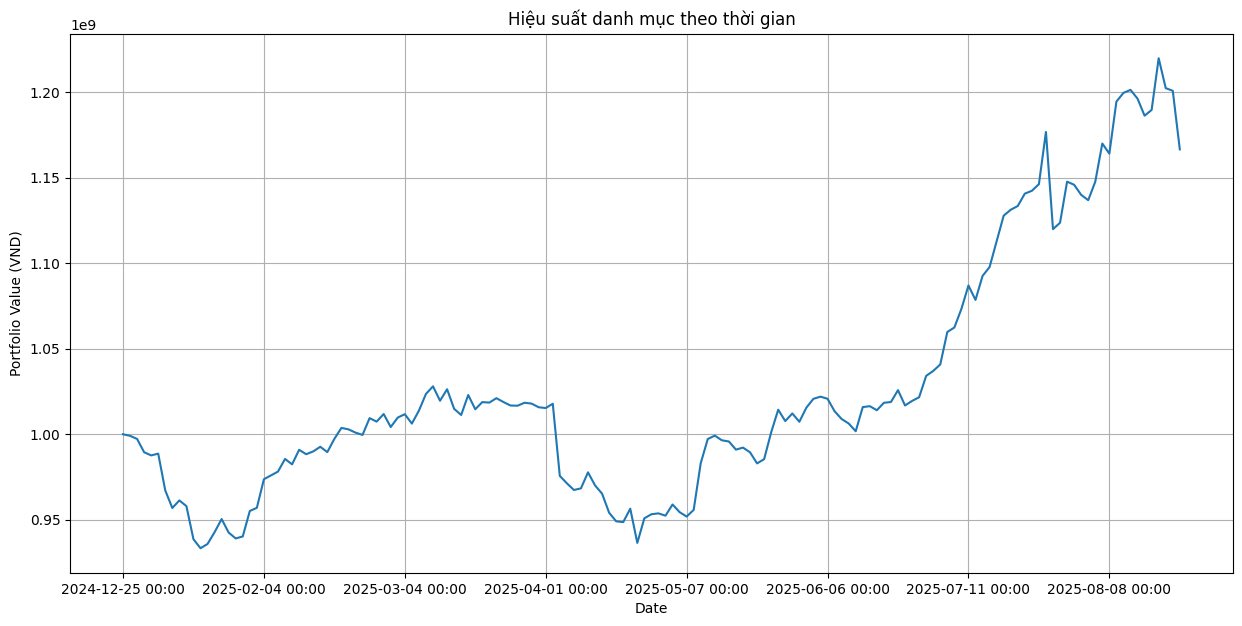

In [61]:
DATA_PATH_UPCOM = r"/kaggle/input/upcom-cleaned/UPCOM_cleaned.xlsx"
DATA_PATH_HOSE = r"/kaggle/input/vnx-cleaned/VNINDEX_cleaned.xlsx"
DATA_PATH_HNX = r"/kaggle/input/hnx-cleaned/HNXINDEX_cleaned.xlsx"
MODEL_PATH = r'/kaggle/input/lstm-weight/best_lstm_classifier_improved.pth'
SCALER_PATH = r"/kaggle/input/scaler-weight/feature_scaler.pkl"


data_upcom = pd.read_excel(DATA_PATH_UPCOM)
data_hose = pd.read_excel(DATA_PATH_HOSE)
data_hnx = pd.read_excel(DATA_PATH_HNX)
data_hose["exchange"] = "HOSE"
data_hnx["exchange"] = "HNX"
data_upcom["exchange"] = "UPCOM"
data_full = pd.concat([data_upcom, data_hose, data_hnx], ignore_index= True)



if data_full is not None:
    signal_model_params = {
        "top_features": ['price_vs_ema200', 'volatility_20', 'volume', 'macd_diff', 'bollinger_bw', 'ema_200', 'volatility_10', 'macd_signal', 'rsi', 'bollinger_pct', 'macd', 'ema_50', 'bollinger_lband', 'mfi_lag_3', 'bollinger_hband'],
        "time_steps": 10, "device": "cpu", "model_path": MODEL_PATH, "scaler_path": SCALER_PATH
    }


    result_df, trade_log_df = run_backtest(
        all_df=data_full,
        RiskClassifier=RiskClassifier,
        vnindex_df = data_hose,
        SignalClassifier=SignalClassifier,
        signal_model_params=signal_model_params,
        initial_balance=1_000_000_000 
    )

    if not result_df.empty:
        analyze_performance(
            portfolio_df=result_df,
            trade_log_df=trade_log_df,
            initial_balance=1_000_000_000 
        )
        
        print("\n--- BIỂU ĐỒ HIỆU SUẤT ---")
        result_df['value'].plot(figsize=(15, 7), title='Hiệu suất danh mục theo thời gian')
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (VND)")
        plt.grid(True)
        plt.show()